In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
import pickle
import matplotlib.lines as mlines
from matplotlib.offsetbox import AnchoredText, HPacker, VPacker, TextArea, AnnotationBbox
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from model_1p7 import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='whitegrid', rc={"font.family": "DejaVu Serif"})
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

# Debug

In [2]:
val, prob, sim, net = simulate('V', 0, 1, 0, trials=80, config='random', pert=0.0)

trial 1
trial 10
trial 20
trial 30
trial 40
trial 50
trial 60
trial 70
trial 80


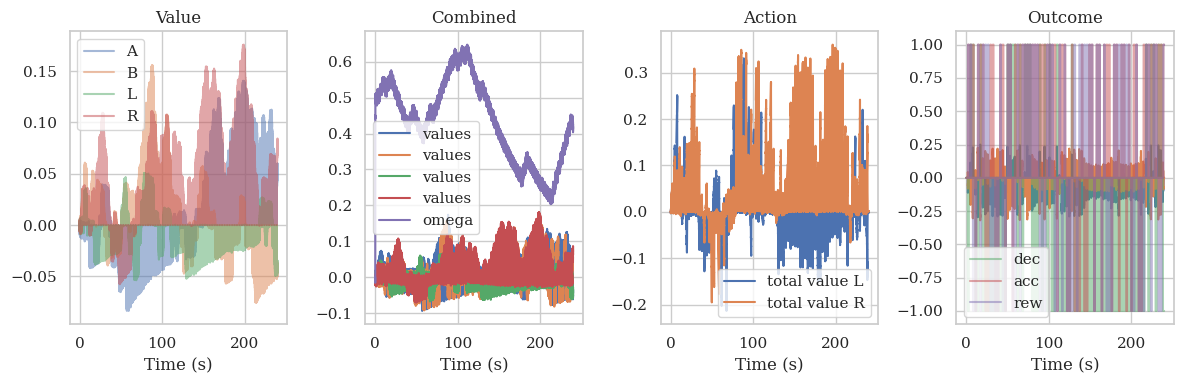

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(12,4))
axes[0].plot(sim.trange(), sim.data[net.p_v][:,0], label='A', alpha=0.5)
axes[0].plot(sim.trange(), sim.data[net.p_v][:,1], label='B', alpha=0.5)
axes[0].plot(sim.trange(), sim.data[net.p_v][:,2], label='L', alpha=0.5)
axes[0].plot(sim.trange(), sim.data[net.p_v][:,3], label='R', alpha=0.5)
axes[1].plot(sim.trange(), sim.data[net.p_vwa][:,:4], label='values')
axes[1].plot(sim.trange(), sim.data[net.p_vwa][:,4], label='omega')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa][:,4], label='vwa')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa2][:,0], label='aL')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa2][:,1], label='aR')
# axes[2].plot(sim.trange(), sim.data[net.p_w])
axes[2].plot(sim.trange(), sim.data[net.p_a][:,0], label='total value L')
axes[2].plot(sim.trange(), sim.data[net.p_a][:,1], label='total value R')
# axes[2].plot(sim.trange(), sim.data[net.p_thr], label='threshold')
axes[3].plot(sim.trange(), sim.data[net.p_ch])
axes[3].plot(sim.trange(), sim.data[net.p_dec][:,0], label='dec', alpha=0.5)
# axes[3].plot(sim.trange(), sim.data[net.p_dec][:,2], label='rt')
axes[3].plot(sim.trange(), sim.data[net.p_rew][:,3], label='acc', alpha=0.5)
axes[3].plot(sim.trange(), sim.data[net.p_rew][:,0], label='rew', alpha=0.5)
# axes[3].plot(sim.trange(), sim.data[net.p_ew])
# axes[3].plot(sim.trange(), sim.data[net.p_mask_learn])
# axes[0].set(xlim=[235,260])
axes[0].set(title='Value', xlabel="Time (s)")  # : 1s ITI, 1s Cue, 1s Rew
axes[1].set(title='Combined', xlabel="Time (s)")
axes[2].set(title='Action', xlabel="Time (s)")
axes[3].set(title='Outcome', xlabel="Time (s)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout()
plt.show()
# fig.savefig("plots/dynamics_2.jpg", dpi=600)

### Loading

In [103]:
pd.read_pickle("data/nef/nef_data_probes.pkl.xz")

monkey  session  block     time        va        vb        vl  \
0           V        0      1    0.001  0.000000  0.000000  0.000000   
1           V        0      1    0.011 -0.004540 -0.002627 -0.002729   
2           V        0      1    0.021 -0.004932  0.001901 -0.003529   
3           V        0      1    0.031 -0.005006  0.000095 -0.002895   
4           V        0      1    0.041 -0.005346  0.000809 -0.003337   
...       ...      ...    ...      ...       ...       ...       ...   
119995      V        0      1  239.951  0.072222 -0.017686 -0.012927   
119996      V        0      1  239.961  0.066257 -0.018685 -0.015761   
119997      V        0      1  239.971  0.070717 -0.018504 -0.016766   
119998      V        0      1  239.981  0.069370 -0.017372 -0.018775   
119999      V        0      1  239.991  0.070245 -0.017124 -0.018797   

              vr        al        ar         w  dec   tdec  thr  rew  acc  
0       0.000000  0.000000  0.000000  0.000000  0.0  0.000  0.7  0.0  0.0  
1      -0.002195 -0.002557  0.000106 -0.029319  0.0  0.000  0.7  0.0  0.0  
2       0.000327  0.001318 -0.000338  0.011371  0.0  0.000  0.7  0.0  0.0  
3      -0.000342 -0.000874  0.000675  0.072733  0.0  0.000  0.7  0.0  0.0  
4      -0.003271 -0.000293 -0.000987  0.130185  0.0  0.000  0.7  0.0  0.0  
...          ...       ...       ...       ...  ...    ...  ...  ...  ...  
119995  0.109043 -0.000779  0.001427  0.711056 -1.0  0.736  0.7  1.0  1.0  
119996  0.108001 -0.000671  0.001249  0.705129 -1.0  0.736  0.7  1.0  1.0  
119997  0.110937 -0.000802  0.001607  0.709334 -1.0  0.736  0.7  1.0  1.0  
119998  0.108659 -0.000692  0.001220  0.704921 -1.0  0.736  0.7  1.0  1.0  
119999  0.108771 -0.000808  0.001292  0.704553 -1.0  0.736  0.7  1.0  1.0  

[120000 rows x 16 columns]

# Load value and probe data files

In [2]:
def classify(row):
    b = row['block']
    if 1 <= b <= 12:
        # Letter blocks: check if it starts with A or B
        start = row['cor_let']
        return f"let_{start}{'B' if start == 'A' else 'A'}"
    elif 13 <= b <= 24:
        # Location blocks: check if starts with left or right
        start_init = 'L' if row['cor_loc'] == 'left' else 'R'
        end_init = 'R' if start_init == 'L' else 'L'
        return f"loc_{start_init}{end_init}"
    return "unknown"

In [3]:
def load_values(filename, do_acc=True, do_delta=True):
    df = pd.read_pickle(filename)
    emp = pd.read_pickle("data/empirical2.pkl")
    if do_acc:
        df['acc'] = df['acc'].replace(-1, 0)
    if do_delta:
        df['dv_let'] = df['vwa_a'] - df['vwa_b']
        df['dv_loc'] = df['vwa_l'] - df['vwa_r']
        df['dv_let_abs'] = np.abs(df['vwa_a'] - df['vwa_b'])
        df['dv_loc_abs'] = np.abs(df['vwa_l'] - df['vwa_r'])
    block_starts = emp[emp['trial'] == 1].copy()
    block_starts['block_label'] = block_starts.apply(classify, axis=1)
    block_type_map = block_starts.set_index('block')['block_label'].to_dict()
    df['block_type'] = df['block'].map(block_type_map)
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    join_keys = ['monkey', 'session', 'block', 'trial']
    extra_cols = ['rev', 'cor_let', 'cor_loc']
    df = df.merge(emp[join_keys + extra_cols], on=join_keys, how='left')
    return df

In [4]:
def load_probes(filename, t_period=3.0):
    df = pd.read_pickle(filename)
    emp = pd.read_pickle("data/empirical2.pkl")
    df['acc'] = df['acc'].replace(-1, 0)
    df['trial'] = (np.floor(df['time'] / t_period) + 1).astype(int)
    df['t_since_cue'] = df['time'] % t_period - 1.0
    emp_subset = emp[['monkey', 'session', 'block', 'trial', 'cor_loc', 'cor_let', 'block_type', 'reversal_at_trial']].drop_duplicates()
    join_keys = ['monkey', 'session', 'block', 'trial']
    df = df.merge(emp_subset, on=join_keys, how='left')
    df['rev'] = df['trial'] - df['reversal_at_trial']
    is_left = (df['cor_loc'] == 'left')
    df['acor'] = np.where(is_left, df['al'], df['ar'])
    df['ainc'] = np.where(is_left, df['ar'], df['al'])
    df['da'] = df['acor'] - df['ainc']
    for col in ['monkey', 'block_type', 'cor_loc', 'cor_let']:
        df[col] = df[col].astype('category')
    return df

In [5]:
nef_values = load_values("data/nef/pert/nef_data_values.pkl.xz")
nef_probes = load_probes("data/nef/pert/nef_data_probes.pkl.xz")
rl_values = load_values("data/rl_values.pkl", do_acc=False, do_delta=False)

In [6]:
# rl_values

# Plot performance and omega

In [7]:
def plot_performance(df, label, window_size=7, x_ratio=0.7):
    nef = df.copy()
    emp = pd.read_pickle("data/empirical2.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    type_map = {'let_AB': 'what', 'let_BA': 'what', 'loc_LR': 'where', 'loc_RL': 'where'}
    nef['super_type'] = nef['block_type'].map(type_map).fillna(nef['block_type'])
    nef['after_rev'] = nef['rev'] >= 0
    nef['smoothed_acc'] = nef.groupby(['monkey', 'super_type', 'session', 'block', 'after_rev'])['acc'].transform(
        lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 4), sharex=True,
                             sharey='row', gridspec_kw={'height_ratios': [x_ratio, 1 - x_ratio]})

    sns.lineplot(data=nef, x='rev', y='smoothed_acc', hue='super_type', hue_order=['what', 'where'], ax=axes[0])
    sns.lineplot(data=nef, x='rev', y='w', hue='super_type', hue_order=['what', 'where'], ax=axes[1])
    # axes[0].set_title(f'NEF Model ({label})')
    axes[0].set(xlim=[-45, 45], ylabel='Task Performance', ylim=[0, 1], yticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    axes[1].set(xlabel='Trial', xlim=[-40, 40], xticks=[-40, -20, 0, 20, 40], xticklabels=[-40, -20, '<rev>', 20, 40], ylabel=r'$\omega$', ylim=[0, 1])
    axes[0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0].legend(title='Block Type')
    axes[1].get_legend().remove()
    axes[0].xaxis.grid(False)  # Explicitly disable vertical lines
    axes[1].xaxis.grid(False)  # Explicitly disable vertical lines

    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/performance_{label}.pdf")
    fig.savefig(f"plots/performance_{label}.svg")
    fig.savefig(f"plots/performance_{label}.jpg", dpi=600)

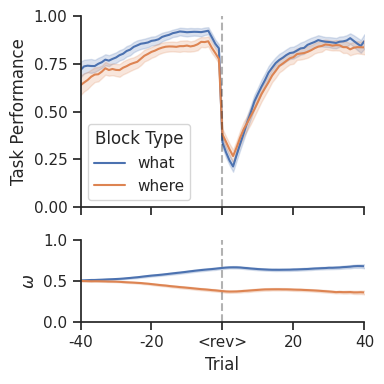

In [8]:
plot_performance(nef_values.query("pert==0.0"), label='control')

# Plot value, omega, and RT dynamics

In [11]:
def set_colored_ylabel(ax, task_type, char_start, char_end):
    # Mapping characters to your specific palette indices
    color_map = {
        'A': palette[0],
        'B': palette[1],
        'L': palette[2],
        'R': palette[3]
    }
    
    # Create the bottom row components: "Char1", " → ", "Char2"
    t1 = TextArea(char_start, textprops=dict(color=color_map[char_start], fontweight='bold', size=11))
    t_arrow = TextArea(" \u2192 ", textprops=dict(size=11))
    t2 = TextArea(char_end, textprops=dict(color=color_map[char_end], fontweight='bold', size=11))
    
    # Pack the row horizontally
    row_arrow = HPacker(children=[t1, t_arrow, t2], align="center", pad=0, sep=0)
    
    # Create the top row: "What" or "Where"
    row_task = TextArea(task_type, textprops=dict(fontweight='bold', size=11))
    
    # Pack top and bottom rows vertically
    final_box = VPacker(children=[row_task, row_arrow], align="center", pad=0, sep=2)
    
    # Place it as the ylabel (axes fraction coordinates)
    # xy=(-0.3, 0.5) puts it to the left of the axis, vertically centered
    ab = AnnotationBbox(final_box, (-0.5, 0.5), xycoords='axes fraction',
                        frameon=False, box_alignment=(0.5, 0.5))
    ax.add_artist(ab)

In [12]:
def plot_values(df, label):
    nef = df.copy()
    target_blocks = ['loc_RL', 'loc_LR', 'let_AB', 'let_BA']
    pretty_labels = {
        'let_AB': 'What\nA \u2192 B',
        'let_BA': 'What\nB \u2192 A',
        'loc_LR': 'Where\nL \u2192 R',
        'loc_RL': 'Where\nR \u2192 L'
    }
    name_map = {'va': 'A', 'vb': 'B', 'vl': 'L', 'vr': 'R'}
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 4), sharex=True, sharey="col")
    for row in range(4):
        if row==0: b_type='let_AB'
        if row==1: b_type='let_BA'
        if row==2: b_type='loc_LR'
        if row==3: b_type='loc_RL'
        block_data = nef.query("block_type==@b_type").copy()
        for col in range(3):
            if col==0: metrics = ['va', 'vb', 'vl', 'vr']
            if col==1: metrics = ['w']
            if col==2: metrics = ['tdec']
            for metric in metrics:
                label_name = name_map.get(metric, metric)
                sns.lineplot(data=block_data, x='rev', y=metric, ax=axes[row][col], label=label_name)
    
    for row in range(4):
        for col in range(3):
            axes[row][col].get_legend().remove()
            if row<3: axes[row][col].set(xlim=[-40, 40], xticks=[-40, 0, 40], ylabel=None)
            if row==3: axes[row][col].set(xlim=[-40, 40], xticks=[-40, 0, 40], xlabel='Trial', xticklabels=[-40, '<rev>', 40], ylabel=None)
            if row==0 and col==0: axes[row][col].set(title="Values")
            if row==0 and col==1: axes[row][col].set(title=r"$\omega$")
            if row==0 and col==2: axes[row][col].set(title="RT")
            # if row==0 and col==0: axes[row][col].set_ylabel('What\nA \u2192 B', rotation=0, labelpad=30, verticalalignment='center')
            # if row==1 and col==0: axes[row][col].set_ylabel('What\nB \u2192 A', rotation=0, labelpad=30, verticalalignment='center')
            # if row==2 and col==0: axes[row][col].set_ylabel('What\nL \u2192 R', rotation=0, labelpad=30, verticalalignment='center')
            # if row==3 and col==0: axes[row][col].set_ylabel('What\nR \u2192 L', rotation=0, labelpad=30, verticalalignment='center')
            if row==0 and col==0: set_colored_ylabel(axes[row][col], "What", "A", "B")
            if row==1 and col==0: set_colored_ylabel(axes[row][col], "What", "B", "A")
            if row==2 and col==0: set_colored_ylabel(axes[row][col], "Where", "L", "R")
            if row==3 and col==0: set_colored_ylabel(axes[row][col], "Where", "R", "L")
            if col==0: axes[row][col].set(ylim=[-0.2,0.2], yticks=[-0.2,0,0.2])
            if col==1: axes[row][col].set(ylim=[0,1], yticks=[0,0.5,1])
            if col==2: axes[row][col].set(ylim=[0.5,0.7], yticks=[0.5,0.7])
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/values_{label}.pdf")
    fig.savefig(f"plots/values_{label}.svg")
    fig.savefig(f"plots/values_{label}.jpg", dpi=600)

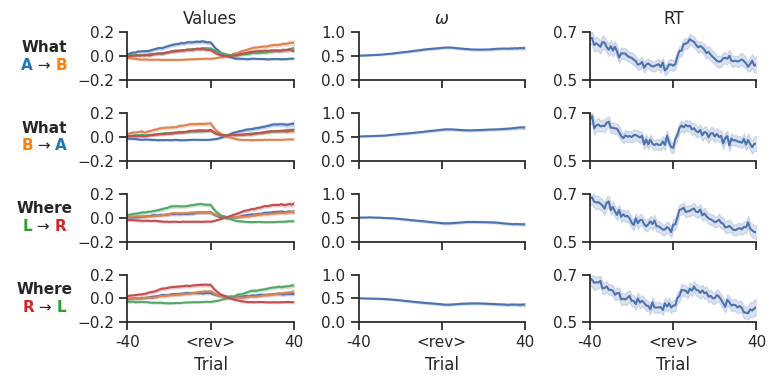

In [13]:
plot_values(nef_values.query("pert==0.0"), label='control')

# Plot total value accumulation within a trial

In [14]:
def plot_ramp(nef, label, trial_start=38, trial_end=45):
    df = nef.query("@trial_start <= rev < @trial_end").copy()
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    sns.lineplot(df, x='t_since_cue', y='da', hue='block_type', ax=axes, color=palette[:2])
    axes.set(xlabel='Time from Cue (s)', ylabel="Total Value")
    axes.axvline(0, color='black', linestyle='--', alpha=0.3)
    axes.set_xticks(np.linspace(-1,1,5))
    axes.set_xlim([-1, 1])
    axes.legend(title="Block Type")
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/ramp_{label}.pdf")
    fig.savefig(f"plots/ramp_{label}.svg")
    fig.savefig(f"plots/ramp_{label}.jpg", dpi=600)

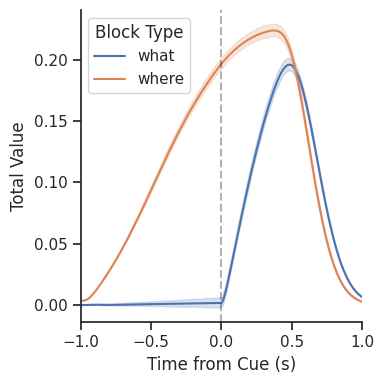

In [16]:
# plot_ramp(nef_probes.query("pert==0.0"), label='control')
plot_ramp(nef_probes, label='control')

# DV perturbed vs control

In [28]:
def plot_dv_pert_vs_ctrl(df, label):
    nef = df.copy()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    scatter_settings = {'alpha': 0.1, 's': 1}
    perts = [0.0, -0.1, -0.2, 0.1, 0.2]
    labels = ["control", "-0.1", "-0.2", "0.1", "0.2"]
    x_data = nef.query("pert==0.0")['dv_let']
    x_data2 = nef.query("pert==0.0")['dv_loc']
    for i, p in enumerate(perts):
        y_data = nef.query(f"pert=={p}")['dv_let']
        y_data2 = nef.query(f"pert=={p}")['dv_loc']
        sns.regplot(x=x_data, y=y_data, ax=axes[0], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
        sns.regplot(x=x_data2, y=y_data2, ax=axes[1], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
    axes[0].set(ylabel=r'$\Delta V$ (control)', xlabel=r'$\Delta V$ (perturbed)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4], title='Letter')
    axes[1].set(ylabel=r'$\Delta V$ (control)', xlabel=r'$\Delta V$ (perturbed)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4], title='Location')
    legend_handles = []
    for i, p in enumerate(perts):
        line = mlines.Line2D([], [], color=palette[i], marker='o', linestyle='-', markersize=8, label=p if i>0 else 'control')
        legend_handles.append(line)
    axes[0].legend(handles=legend_handles, title=r"Perturbation ($\Delta \omega$)", loc='upper left', frameon=True)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/dv_pert_vs_ctrl_{label}.pdf")
    fig.savefig(f"plots/dv_pert_vs_ctrl_{label}.svg")
    fig.savefig(f"plots/dv_pert_vs_ctrl_{label}.jpg", dpi=600)

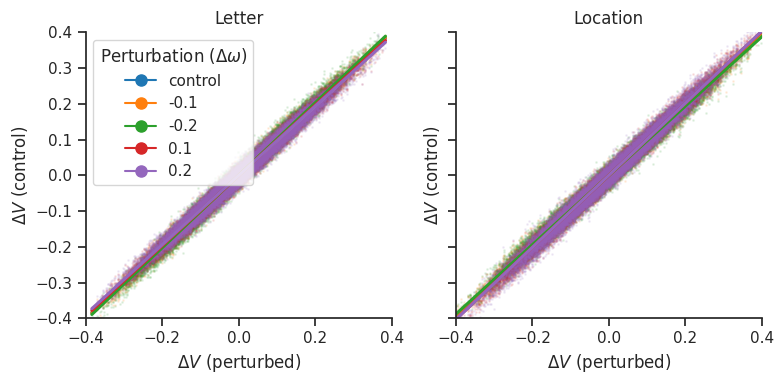

In [29]:
plot_dv_pert_vs_ctrl(nef_values, label='single')

# Decision perturbed vs control

In [78]:
def plot_dec_pert_vs_ctrl(df, label):
    nef = df.copy()
    perts = [0.0, -0.1, -0.2, 0.1, 0.2]
    labels = ["control", "-0.1", "-0.2", "0.1", "0.2"]
    identifiers = ['monkey', 'session', 'block', 'seed', 'trial']
    df_ctrl = nef.query("pert == 0.0")
    n_samples = len(df_ctrl)
    results = []
    for p in perts[1:]:
        df_pert = nef.query("pert == @p")
        aligned = pd.merge(df_ctrl, df_pert, on=identifiers, suffixes=('_base', '_pert'))
        is_different = (aligned['dec_base'] != aligned['dec_pert'])
        prob_diff = is_different.mean() * 100
        results.append({'Perturbation': p, 'Percentage': prob_diff})
    plot_df = pd.DataFrame(results)

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    sns.barplot(data=plot_df, x='Perturbation', y='Percentage', ax=axes, palette=palette[1:5], hue='Perturbation', legend=False)
    for p_bar in axes.patches:
        height = p_bar.get_height()
        axes.annotate(f'{height:.1f}%', (p_bar.get_x() + p_bar.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 7), textcoords='offset points')
    axes.set(ylabel="Trials Different (%)", xlabel=r"Perturbation ($\Delta \omega$)", ylim=[0,18], yticks=[0,18])
    axes.set_title("Choice Differences Following Perturbation", pad=20)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/dec_pert_vs_ctrl_{label}.pdf")
    fig.savefig(f"plots/dec_pert_vs_ctrl_{label}.svg")
    fig.savefig(f"plots/dec_pert_vs_ctrl_{label}.jpg", dpi=600)

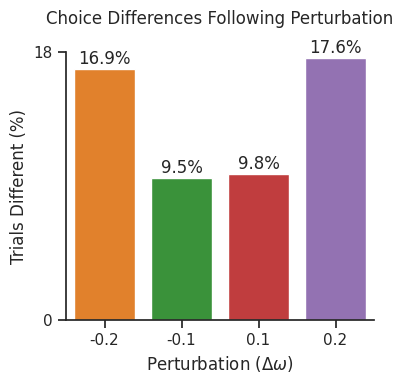

In [79]:
plot_dec_pert_vs_ctrl(nef_values, label='single')

# Perturbation during training

In [7]:
# control = adjust_df(pd.read_pickle("data/nef/control/nef_data.pkl.xz"))
spkk = adjust_df(pd.read_pickle("data/nef/spikes/nef_data.pkl.xz")).query("pert_value==0.0")
# pert = adjust_df(pd.read_pickle("data/nef/nef_data.pkl.xz")).query("pert==0.0")
# inh = adjust_df(pd.read_pickle("data/nef/inh/nef_data.pkl.xz"))
# pos = adjust_df(pd.read_pickle("data/nef/pos/nef_data.pkl.xz"))
# neg = adjust_df(pd.read_pickle("data/nef/neg/nef_data.pkl.xz"))
rl = adjust_df(pd.read_pickle("data/rl_values.pkl"), False, False)

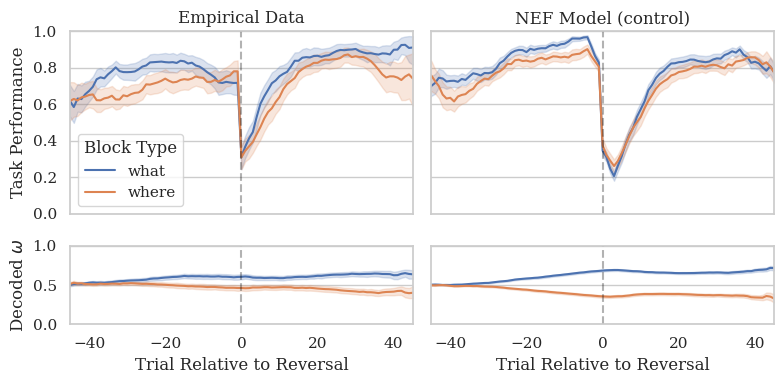

In [315]:
plot_performance_omega(spkk, rl, label='control')

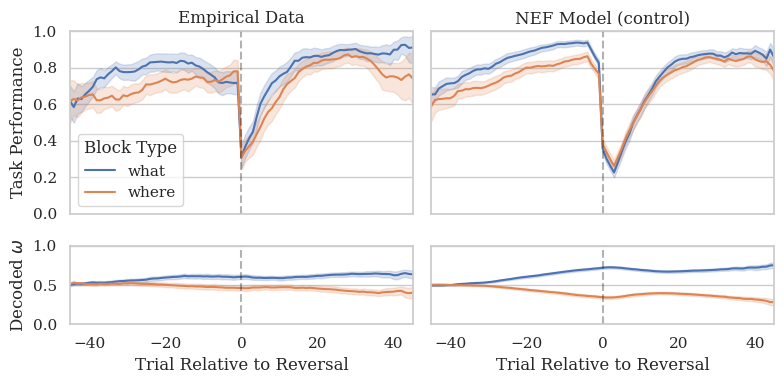

In [49]:
plot_performance_omega(control, rl, label='control')

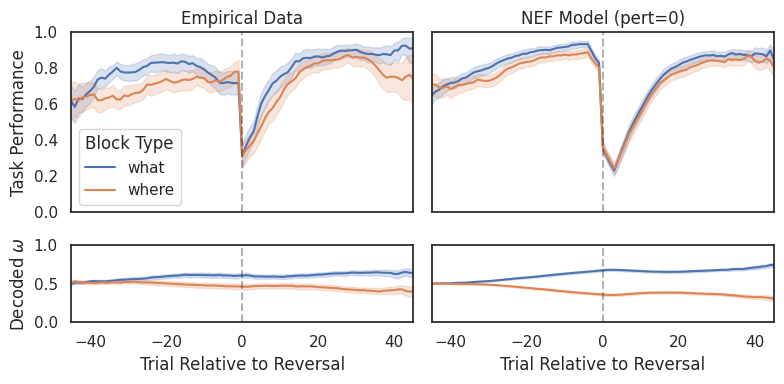

In [77]:
plot_performance_omega(pert, rl, label='pert=0')

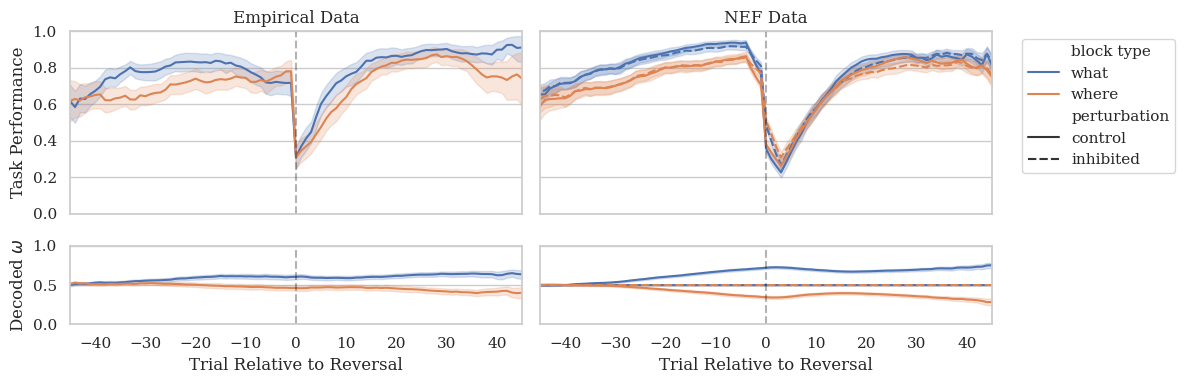

In [50]:
plot_control_inhibited(control, inh, rl)

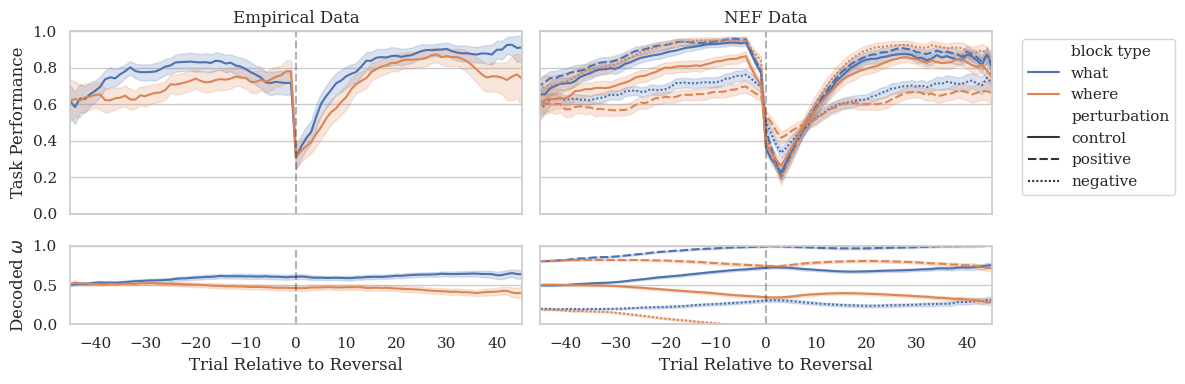

In [56]:
plot_control_pos_neg(control, pos, neg, rl)

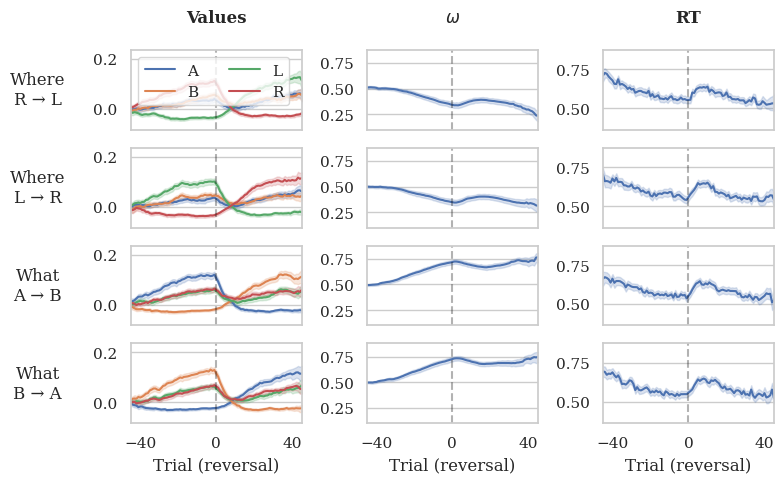

In [33]:
plot_values(control)

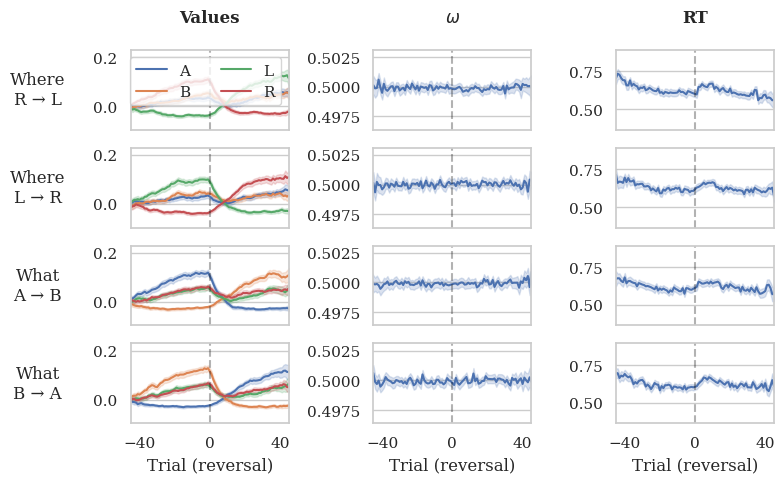

In [57]:
plot_values(inh)

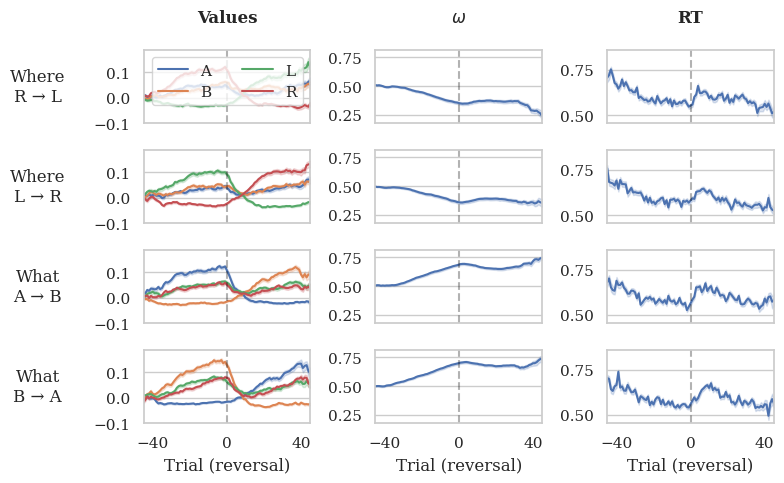

In [96]:
plot_values(pert.query("pert_value==0.0"))

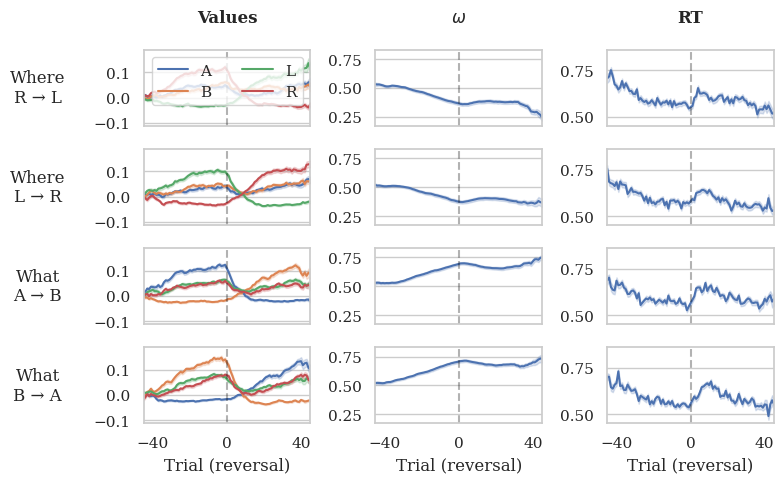

In [97]:
plot_values(pert.query("pert_value==0.2"))

# Ramping

In [9]:
def plot_ramp(df, label, trial_start=38, trial_end=45):
    df = df.query("@trial_start <= rev < @trial_end").copy()
    type_map = {'what': 'What Blocks', 'where': 'Where Blocks'}
    df['super_type'] = df['block_type'].map(type_map)
    categories = ['Where Blocks', 'What Blocks']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True, sharex=True)
    for i, cat in enumerate(categories):
        data_subset = df[df['super_type'] == cat]
        sns.lineplot(data=data_subset, x='t_since_cue', y='da', ax=axes[i], color=palette[0], alpha=1)
        # sns.lineplot(data=data_subset, x='t_since_cue', y='acor', ax=axes[i], color=palette[1], alpha=0.3, label='a correct')
        # sns.lineplot(data=data_subset, x='t_since_cue', y='ainc', ax=axes[i], color=palette[2], alpha=0.3, label='a incorrect')
        # sns.lineplot(data=data_subset, x='t_since_cue', y='thr', ax=axes[i], color=palette[3], alpha=0.3, label='a thr')
        axes[i].set_title(cat+f" ({label})", fontweight='bold', fontsize=14)
        axes[i].set(xlabel='Time from Cue (s)', ylabel="Action Value\n(v correct - v incorrect)" if i == 0 else None)
        axes[i].axvline(0, color='black', linestyle='--', alpha=0.3)
        axes[i].set_xticks(np.linspace(-1,1,5))
        axes[i].set_xlim([-1, 1])
    # axes[0].set(ylim=[0,0.7])
    # axes[1].set(ylim=[0,0.2], yticks=[0.0, 0.05, 0.1, 0.15, 0.2])
    # axes[0].legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/ramp_{label}.pdf")
    fig.savefig(f"plots/ramp_{label}.jpg", dpi=600)

In [53]:
control_full = load_adjust_full(pd.read_pickle("data/nef/control/nef_data_full.pkl.xz"))
inh_full = load_adjust_full(pd.read_pickle("data/nef/inh/nef_data_full.pkl.xz"))
pos_full = load_adjust_full(pd.read_pickle("data/nef/pos/nef_data_full.pkl.xz"))
neg_full = load_adjust_full(pd.read_pickle("data/nef/neg/nef_data_full.pkl.xz"))

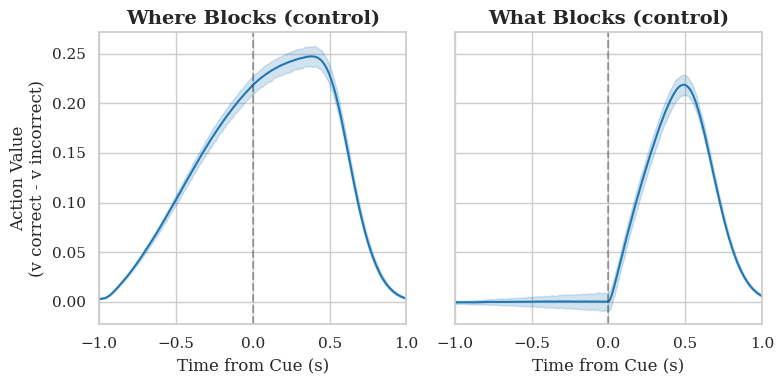

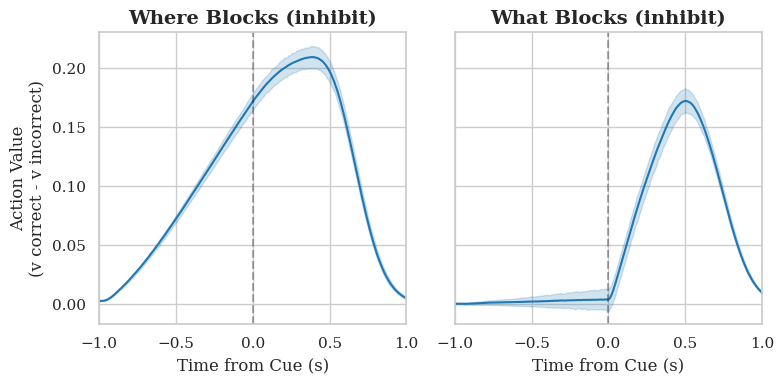

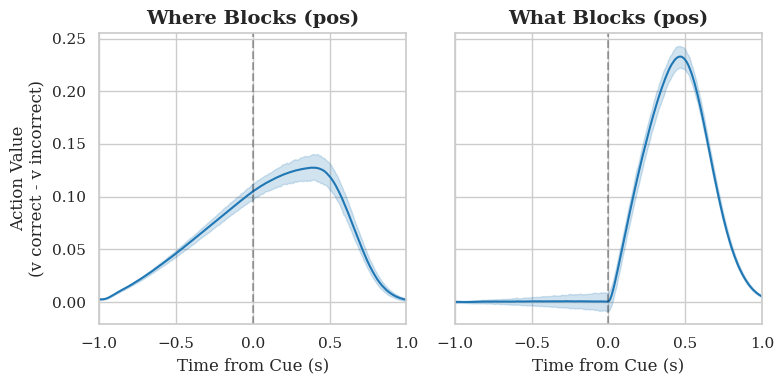

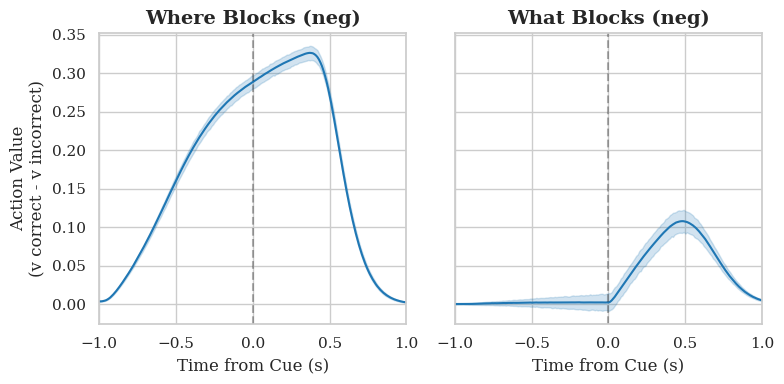

In [54]:
plot_ramp(control_full, "control")
plot_ramp(inh_full, "inhibit")
plot_ramp(pos_full, "pos")
plot_ramp(neg_full, "neg")

# Decoding internal states and actions under perturbation

## DV_let and DV_loc

In [92]:
pert = adjust_df(pd.read_pickle("data/nef/nef_data_pert.pkl.xz"))

In [38]:
def plot_dv_decoding(pert):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    scatter_settings = {'alpha': 0.3, 's': 10}
    perts = [0.0, -0.1, -0.2, 0.1, 0.2]
    labels = ["control", "-0.1", "-0.2", "0.1", "0.2"]
    x_data = pert.query("pert==0.0")['dv_let']
    x_data2 = pert.query("pert==0.0")['dv_loc']
    for i, p in enumerate(perts):
        y_data = pert.query(f"pert=={p}")['dv_let']
        y_data2 = pert.query(f"pert=={p}")['dv_loc']
        sns.regplot(x=x_data, y=y_data, ax=axes[0], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
        sns.regplot(x=x_data2, y=y_data2, ax=axes[1], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
    axes[0].set(ylabel=r'$\Delta V_{let}$ (control)', xlabel=r'$\Delta V_{let}$ (perturbed)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4])
    axes[1].set(ylabel=r'$\Delta V_{loc}$ (control)', xlabel=r'$\Delta V_{loc}$ (perturbed)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4])
    axes[0].legend()
    plt.tight_layout()
    plt.show()

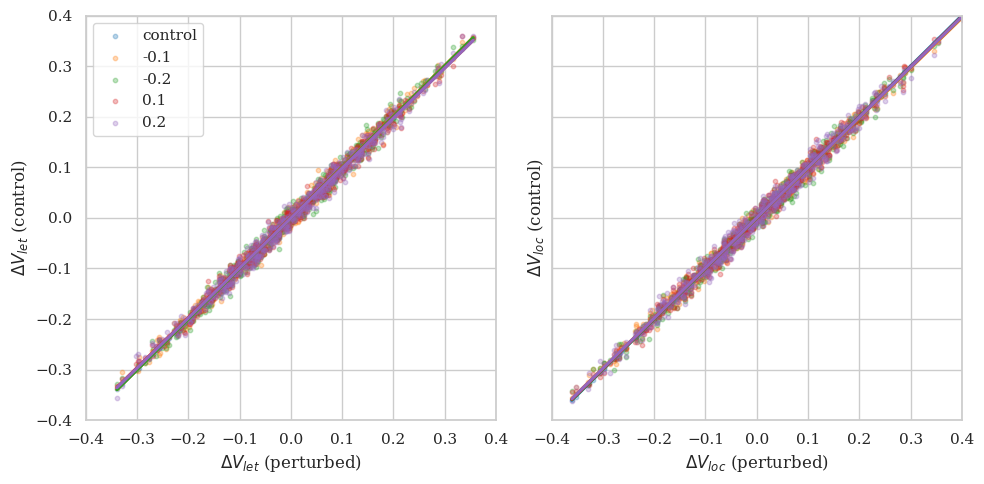

In [39]:
plot_dv_decoding(pert)

## a_L and a_R

In [96]:
def plot_action_decoding(pert):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    scatter_settings = {'alpha': 0.3, 's': 10}
    perts = [0.0, -0.1, -0.2, 0.1, 0.2]
    labels = ["control", "-0.1", "-0.2", "0.1", "0.2"]
    x_data = pert.query("pert==0.0")['al']
    x_data2 = pert.query("pert==0.0")['ar']
    for i, p in enumerate(perts):
        y_data = pert.query(f"pert=={p}")['al']
        y_data2 = pert.query(f"pert=={p}")['ar']
        sns.regplot(x=x_data, y=y_data, ax=axes[0], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
        sns.regplot(x=x_data2, y=y_data2, ax=axes[1], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
    axes[0].set(ylabel=r'$a_{L}$ (control)', xlabel=r'$a_{L}$ (perturbed)')
    axes[1].set(ylabel=r'$a_{R}$ (control)', xlabel=r'$a_{R}$ (perturbed)')
    axes[0].legend()
    plt.tight_layout()
    plt.show()

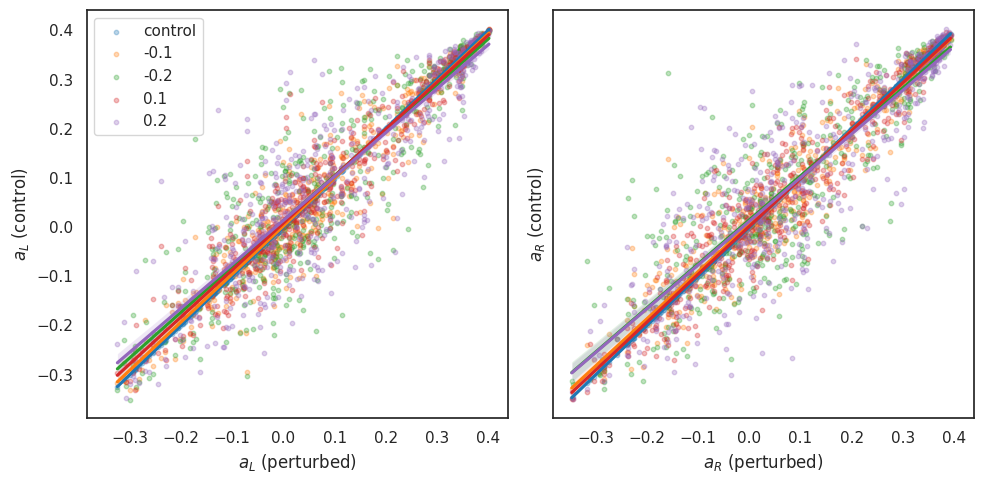

In [97]:
plot_action_decoding(pert)

In [106]:
def plot_action_decoding2(pert):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
    scatter_settings = {'alpha': 0.3, 's': 10}
    perts = [0.0, -0.1, -0.2, 0.1, 0.2]
    labels = ["control", "-0.1", "-0.2", "0.1", "0.2"]
    x_data = pert.query("pert==0.0")['al']
    x_data2 = pert.query("pert==0.0")['ar']
    for i, p in enumerate(perts):
        y_data = pert.query(f"pert=={p}")['al']
        y_data2 = pert.query(f"pert=={p}")['ar']
        sns.regplot(x=x_data, y=y_data, ax=axes[0][i], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
        sns.regplot(x=x_data2, y=y_data2, ax=axes[1][i], color=palette[i], label=labels[i], scatter_kws=scatter_settings)
        axes[0][i].set(xlabel=r'$a_{L}$ (perturbed)', ylabel=None, title=f'Perturb={p}')
        axes[1][i].set(xlabel=r'$a_{R}$ (perturbed)', ylabel=None)
    axes[0][0].set(ylabel=r'$a_{L}$ (control)')
    axes[1][0].set(ylabel=r'$a_{R}$ (control)')
    plt.tight_layout()
    plt.show()

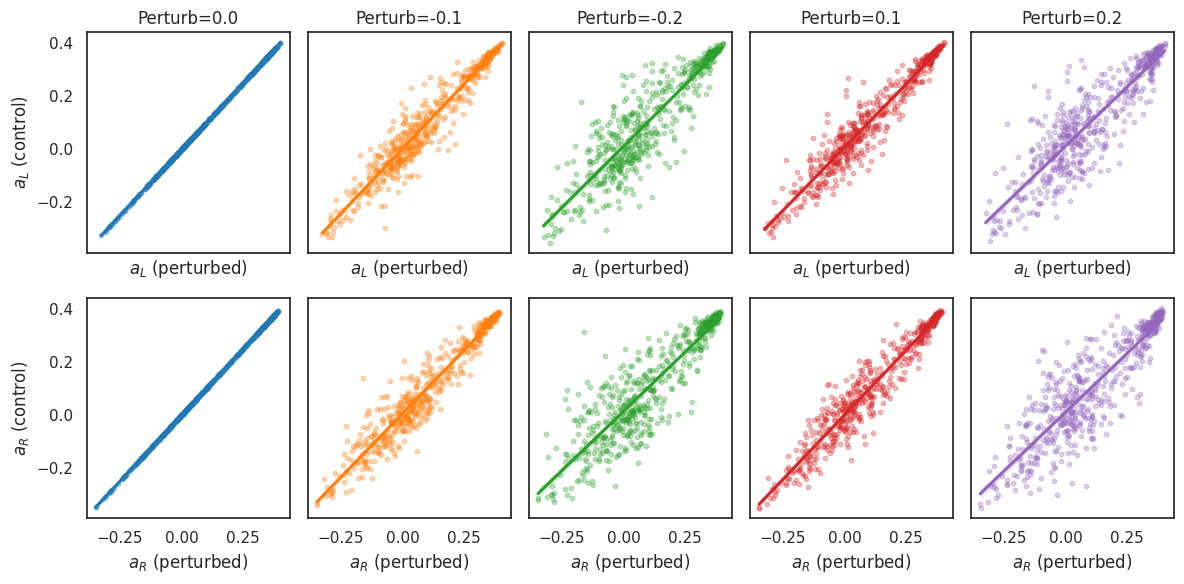

In [107]:
plot_action_decoding2(pert)

## Decision

In [68]:
def plot_error_probability(df):
    p2 = [palette[1], palette[2], palette[0], palette[3], palette[4]]
    df = df.copy()
    df['trial_id'] = df.groupby('pert').cumcount()
    pivot_df = df.pivot(index='trial_id', columns='pert', values='dec')
    results = []
    control_col = 0.0
    all_perts = sorted(pivot_df.columns) 
    for p in all_perts:
        is_different = (pivot_df[control_col] != pivot_df[p])
        prob_diff = is_different.mean()
        results.append({'Perturbation': p,'Percentage': prob_diff * 100})
    plot_df = pd.DataFrame(results)
    plt.figure(figsize=(8, 5))
    sns.set_style("white")
    ax = sns.barplot(data=plot_df, x='Perturbation', y='Percentage', hue='Perturbation', palette=p2)
    # ax.legend(title="Perturbation", loc='upper center')
    ax.get_legend().remove()
    for p_bar in ax.patches:
        height = p_bar.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}%', 
                    (p_bar.get_x() + p_bar.get_width() / 2., height), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=10, weight='bold')
    ax.set(ylabel="Percent of Trials Different (%)", xlabel="Perturbation Level ($w$)")
    current_max = plot_df['Percentage'].max()
    ax.set_ylim(0, max(current_max * 1.2, 10))
    sns.despine()
    plt.tight_layout()
    plt.show()

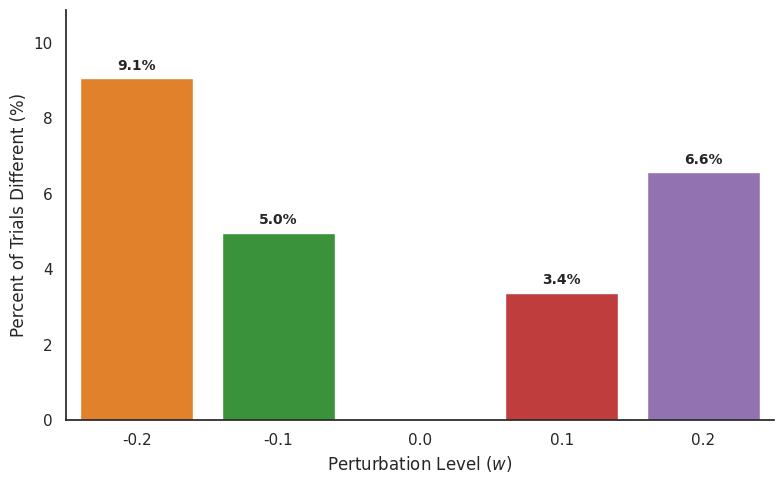

In [69]:
plot_error_probability(pert)

## deltaV vs omega

In [170]:
def plot_dv_vs_omega(df, x_bins = np.linspace(0.2,0.8,7), sharex=True, sharey=True):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    sns.regplot(df, x='w', y='dv_let_abs', ax=axes[0], x_bins=x_bins, color=palette[0], fit_reg=False, scatter_kws={'s':5})
    sns.regplot(df, x='w', y='dv_loc_abs', ax=axes[1], x_bins=x_bins, color=palette[0], fit_reg=False, scatter_kws={'s':5})
    axes[0].set(xlabel='omega', title=r"abs($v_A - v_B$)", ylabel=r"$|\Delta V|$", xticks=x_bins, xlim=[x_bins[0]-0.1, x_bins[-1]+0.1])
    axes[1].set(xlabel='omega', title=r"abs($v_L - v_R$)", ylabel=None, yticks=[], xticks=x_bins, xlim=[x_bins[0]-0.1, x_bins[-1]+0.1])
    plt.tight_layout()
    plt.show()

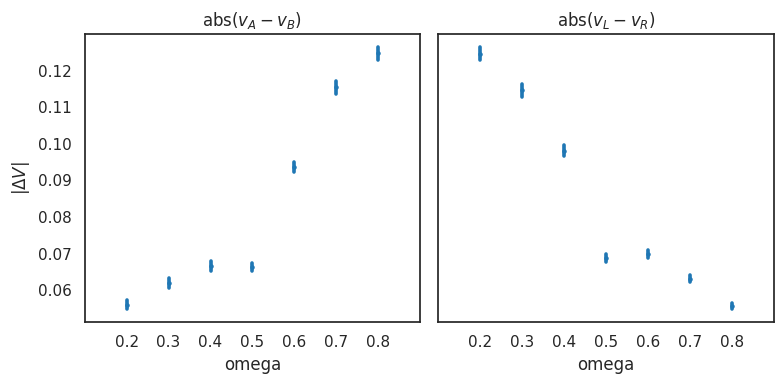

In [171]:
plot_dv_vs_omega(control)

# Decoding from full perturbation runs

## Looking at the trial when perturbation was applied, regress dv_let and dv_loc in perturbed and unperturbed case
Then further split by omega bin

In [71]:
def plot_dv_decoding_by_omega(pert_range, omega_bins=np.linspace(0.2,0.8,6), ahead=[0,1], pert_starts=np.arange(1, 91, 10)):
    fig, axes = plt.subplots(nrows=2, ncols=len(omega_bins)-1, figsize=(12, 5), sharex=True, sharey=True)
    perts = pert_range['pert_value'].unique()
    start_offset, end_offset = ahead[0], ahead[1]
    df = pert_range.query("pert_start + @start_offset <= trial < pert_start + @end_offset & pert_start in @pert_starts")
    identifiers = ['monkey', 'session', 'block', 'trial']
    for j in range(len(omega_bins)-1):
        for row in range(2):
            axes[row][j].plot([-0.4, 0.4], [-0.4, 0.4], color='gray', linestyle='--', linewidth=1, zorder=0)
        w_min, w_max = omega_bins[j], omega_bins[j+1]
        df_w = df.query("pert_value == 0.0 & @w_min < w < @w_max")
        n_samples = len(df_w)
        for i, p in enumerate(perts):
            df_p = df.query("pert_value == @p")
            aligned = pd.merge(df_w, df_p, on=identifiers, suffixes=('_base', '_pert'))
            x_data, x_data2 = aligned['dv_let_base'], aligned['dv_loc_base']
            y_data, y_data2 = aligned['dv_let_pert'], aligned['dv_loc_pert']
            if not aligned.empty:
                sns.regplot(x=x_data, y=y_data, ax=axes[0][j], color=palette[i], label=p, scatter_kws={'alpha': 0.3, 's': 10})
                sns.regplot(x=x_data2, y=y_data2, ax=axes[1][j], color=palette[i], label=p, scatter_kws={'alpha': 0.3, 's': 10})
        axes[0][j].set(title=f"{w_min:.2}<w<{w_max:.2}\n(n={n_samples})", ylabel=None, xlabel=r'$\Delta V_{let}$ (pert)')
        axes[1][j].set(ylabel=None, xlabel=r'$\Delta V_{loc}$ (pert)')
    axes[0][0].set(ylabel=r'$\Delta V_{let}$ (control)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4], xticks=[-0.4, 0, 0.4], yticks=[-0.4,0,0.4])
    axes[1][0].set(ylabel=r'$\Delta V_{loc}$ (control)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4], xticks=[-0.4, 0, 0.4], yticks=[-0.4,0,0.4])
    axes[0][0].legend(title='Perturbation')
    plt.tight_layout()
    plt.show()

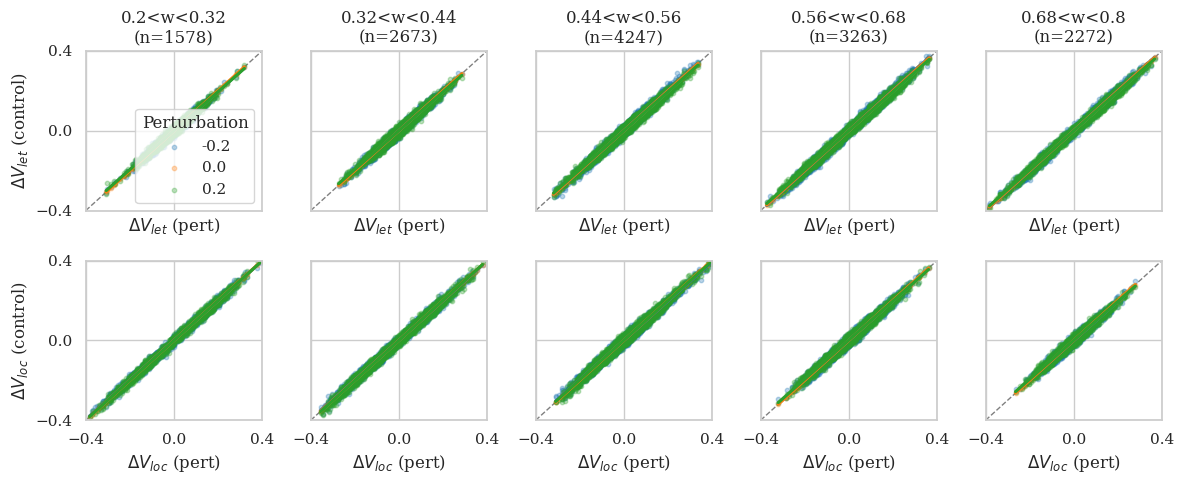

In [128]:
plot_dv_decoding_by_omega(pert_range, ahead=[0,10])

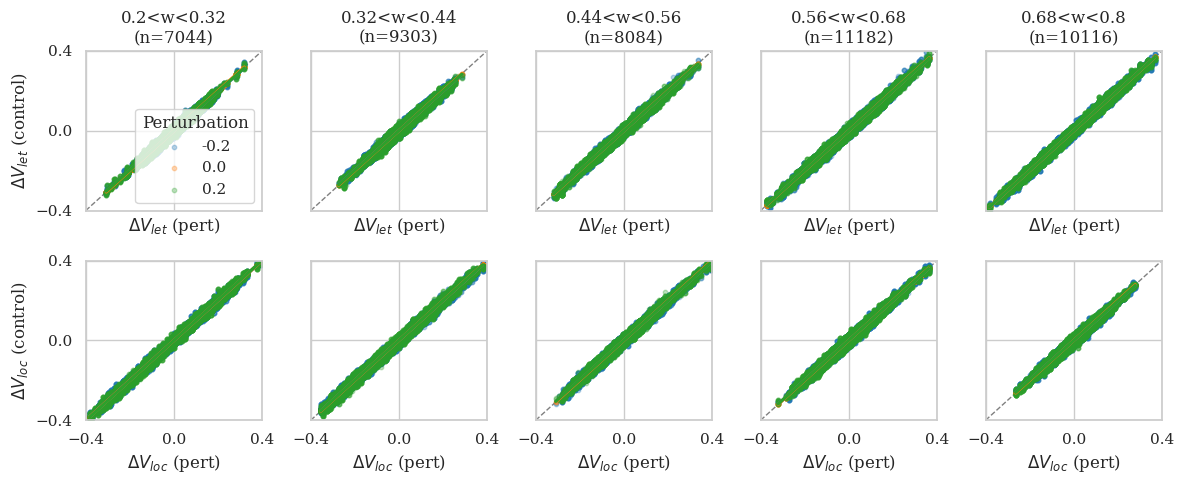

In [129]:
plot_dv_decoding_by_omega(pert_range, ahead=[10,70])

In [125]:
def plot_error_probability_by_omega(partial, omega_bins=np.linspace(0.2, 0.8, 6), ahead=[0,1], pert_starts=np.arange(1,91,10)):
    fig, axes = plt.subplots(nrows=1, ncols=len(omega_bins)-1, figsize=(16, 4), sharey=True)
    perts = sorted(partial['pert_value'].unique())
    start_offset, end_offset = ahead[0], ahead[1]
    df = pert_range.query("pert_start + @start_offset <= trial < pert_start + @end_offset & pert_start in @pert_starts")
    identifiers = ['monkey', 'session', 'block', 'trial']

    for j in range(len(omega_bins)-1):
        w_min, w_max = omega_bins[j], omega_bins[j+1]
        df_w = df.query("pert_value == 0.0 & @w_min < w < @w_max")
        n_samples = len(df_w) # Number of baseline trials found
        ax = axes[j]
        
        results = []
        for p in perts:
            df_p = df.query("pert_value == @p")
            aligned = pd.merge(df_w, df_p, on=identifiers, suffixes=('_base', '_pert'))
            
            if not aligned.empty:
                is_different = (aligned['dec_base'] != aligned['dec_pert'])
                prob_diff = is_different.mean() * 100
                results.append({'Perturbation': p, 'Percentage': prob_diff})
        
        if results:
            plot_df = pd.DataFrame(results)
            sns.barplot(data=plot_df, x='Perturbation', y='Percentage', ax=ax, palette=palette[:3], hue='Perturbation', legend=False)
            
            for p_bar in ax.patches:
                height = p_bar.get_height()
                ax.annotate(f'{height:.1f}%', 
                            (p_bar.get_x() + p_bar.get_width() / 2., height),
                            ha='center', va='center', xytext=(0, 7),
                            textcoords='offset points', fontsize=9, weight='bold')
            
            ax.set_title(f"{w_min:.2}<w<{w_max:.2}\n(n={n_samples})")
            ax.set_xlabel("Pert Level")
        else:
            ax.set_title(f"{w_min:.2}<w<{w_max:.2}\n(n=0)")
            ax.set_xticks([])

    fig.suptitle(f"Error Probability vs Omega (when Perturbation was applied):\nEffects on the subsequent {ahead[0]}-{ahead[1]} Trials")
    axes[0].set_ylabel("Trials Different (%)")
    axes[0].set(ylim=[0,30])
    sns.despine()
    plt.tight_layout()
    plt.show()

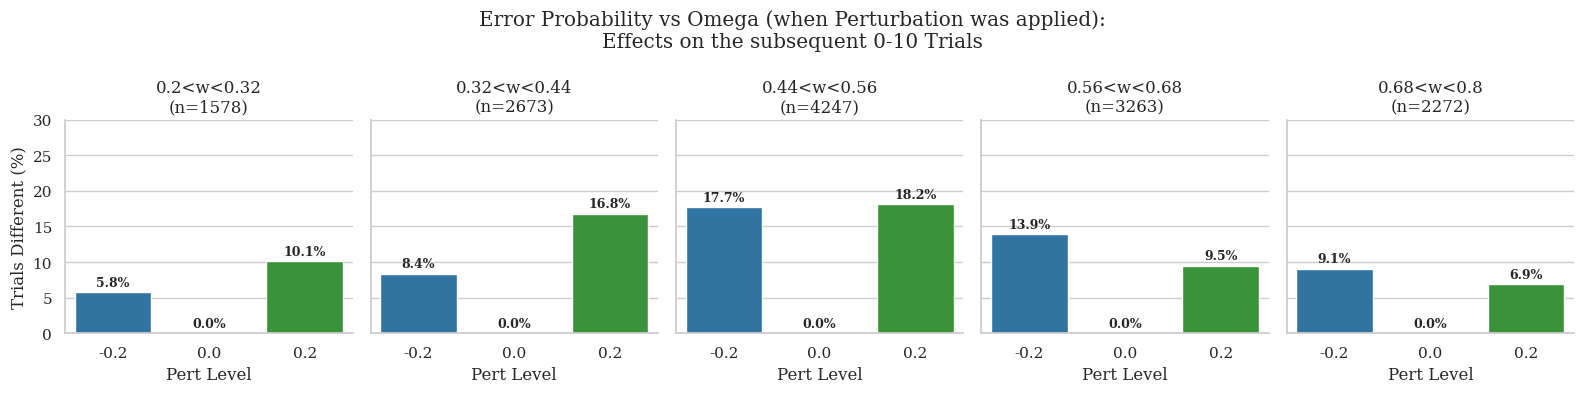

In [126]:
plot_error_probability_by_omega(pert_range, ahead=[0,10])

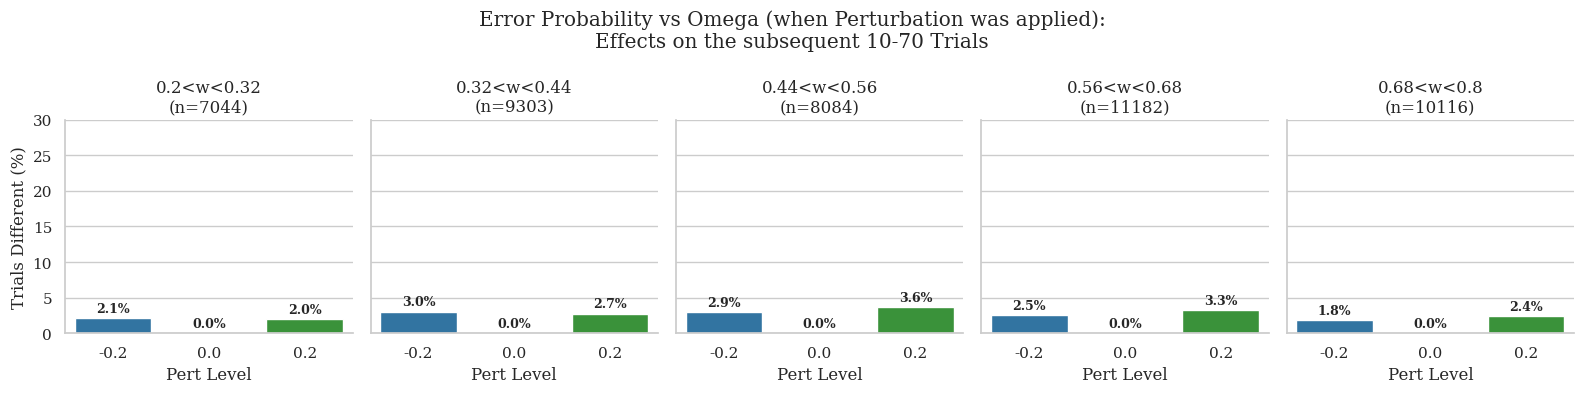

In [127]:
plot_error_probability_by_omega(pert_range, ahead=[10,70])

## Error timecourse

In [115]:
def plot_error_timecourse(pert_range, max_ahead=80, pert_starts=np.arange(1,91,10)):
    fig, ax = plt.subplots(figsize=(12,6))
    perts = sorted(pert_range['pert_value'].unique())
    identifiers = ['monkey', 'session', 'block']
    all_results = []
    for p_val in perts:
        if p_val == 0.0: continue
        for start in pert_starts:
            for d in range(max_ahead):
                target_trial = start + d
                df_step = pert_range.query("pert_start == @start & trial == @target_trial")
                df_w = df_step.query("pert_value == 0.0")
                df_p = df_step.query("pert_value == @p_val")
                aligned = pd.merge(df_w, df_p, on=identifiers, suffixes=('_base', '_pert'))
                if not aligned.empty:
                    is_different = (aligned['dec_base'] != aligned['dec_pert']).mean() * 100
                    all_results.append({
                        'Trial': target_trial,
                        'Relative_Trial': d,
                        'Pert_Start': start,
                        'Pert_Value': p_val,
                        'Error_Prob': is_different
                    })
    if all_results:
        plot_df = pd.DataFrame(all_results)
        sns.lineplot(data=plot_df, x='Trial', y='Error_Prob', hue='Pert_Start', style='Pert_Value', palette=sns.color_palette("husl", 8), ax=ax)

    plt.title("Error Probability Following Perturbations")
    plt.ylabel("Trials Different (%)")
    plt.xlabel("Trial Number")
    plt.ylim(0, 40)
    plt.legend()
    plt.tight_layout()
    plt.show()

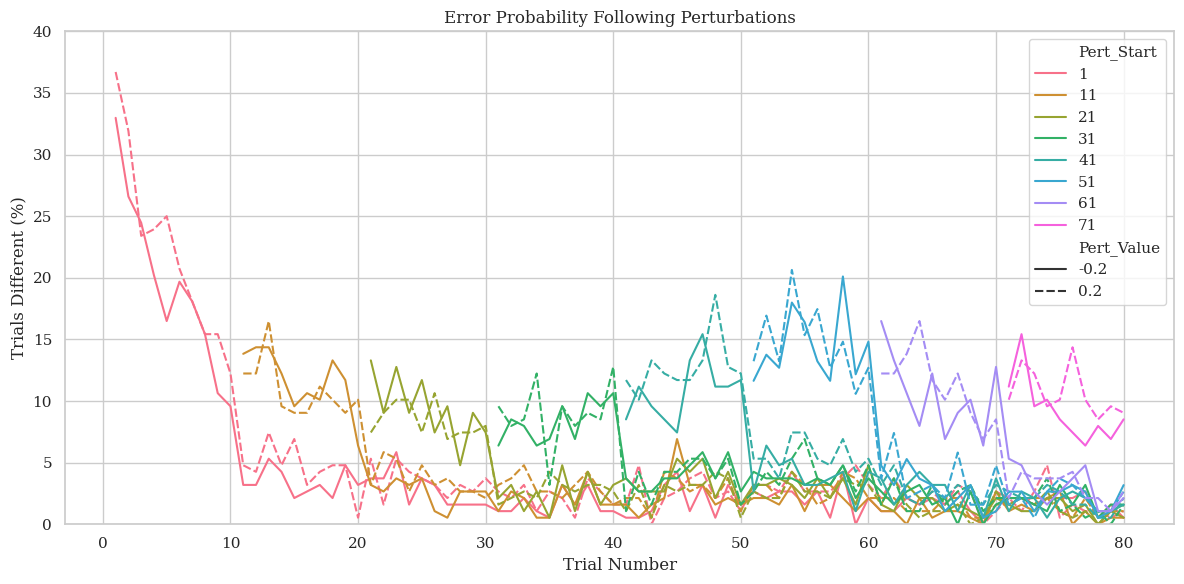

In [116]:
plot_error_timecourse(pert_range)

## Alignment of Loc/Let Value and Total Value 

In [11]:
pert = adjust_df(pd.read_pickle("data/nef/spikes/nef_data.pkl.xz"))

In [34]:
def plot_dv_decoding_by_omega(pert, n_omega_bins=5, ahead=[0,1], pert_starts=np.arange(1, 91, 10)):
    fig, axes = plt.subplots(nrows=2, ncols=n_omega_bins, figsize=(12, 5), sharex=True, sharey=True)
    perts = pert['pert_value'].unique()
    start_offset, end_offset = ahead[0], ahead[1]
    df = pert.copy().query("pert_start + @start_offset <= trial < pert_start + @end_offset & pert_start in @pert_starts")
    df['w_quantile'] = pd.qcut(df['w'], n_omega_bins, labels=False)
    identifiers = ['monkey', 'session', 'block', 'trial']
    for q in range(n_omega_bins):
        for row in range(2):
            axes[row][q].plot([-0.4, 0.4], [-0.4, 0.4], color='gray', linestyle='--', linewidth=1, zorder=0)
        df_w = df.query("pert_value == 0.0 & w_quantile==@q")
        n_samples = len(df_w)
        w_mean = df_w['w'].mean()
        for i, p in enumerate(perts):
            df_p = df.query("pert_value == @p")
            aligned = pd.merge(df_w, df_p, on=identifiers, suffixes=('_base', '_pert'))
            x_data, x_data2 = aligned['dv_let_base'], aligned['dv_loc_base']
            y_data, y_data2 = aligned['dv_let_pert'], aligned['dv_loc_pert']
            if not aligned.empty:
                sns.regplot(x=x_data, y=y_data, ax=axes[0][q], color=palette[i], label=p, scatter_kws={'alpha': 0.3, 's': 10})
                sns.regplot(x=x_data2, y=y_data2, ax=axes[1][q], color=palette[i], label=p, scatter_kws={'alpha': 0.3, 's': 10})
        axes[0][q].set(title=f"w_{q}\nw mean={w_mean:.2}\nn={n_samples}", ylabel=None, xlabel=r'$\Delta V_{let}$ (pert)')
        axes[1][q].set(ylabel=None, xlabel=r'$\Delta V_{loc}$ (pert)')
    axes[0][0].set(ylabel=r'$\Delta V_{let}$ (control)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4], xticks=[-0.4, 0, 0.4], yticks=[-0.4,0,0.4])
    axes[1][0].set(ylabel=r'$\Delta V_{loc}$ (control)', xlim=[-0.4, 0.4], ylim=[-0.4, 0.4], xticks=[-0.4, 0, 0.4], yticks=[-0.4,0,0.4])
    axes[0][0].legend(title='Perturbation')
    plt.tight_layout()
    plt.show()

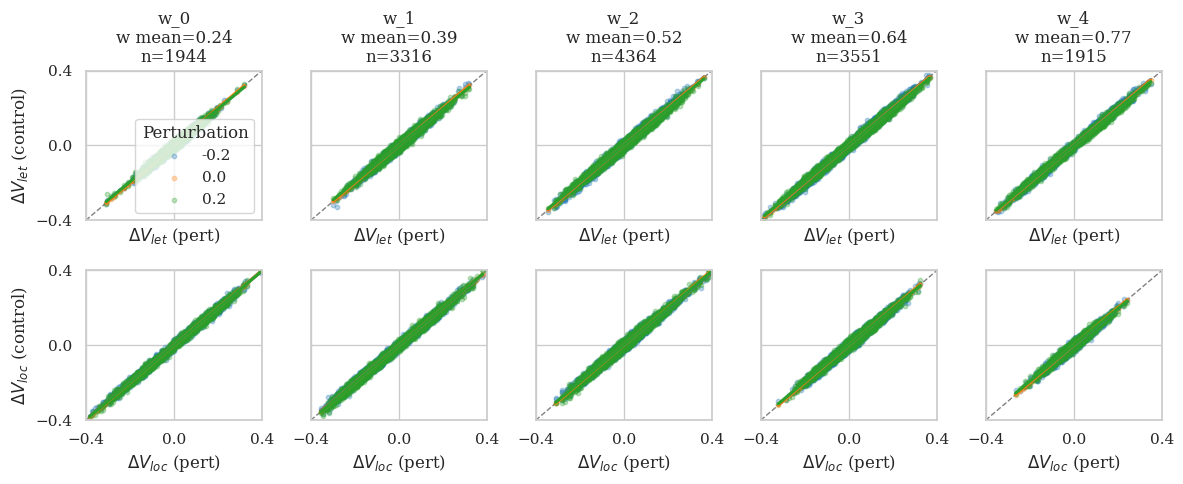

In [33]:
plot_dv_decoding_by_omega(pert, ahead=[0,10])

In [93]:
def plot_alignment_by_omega(pert, n_omega_bins=5, ahead=[0,1], pert_starts=np.arange(1, 91, 10), do_scatter=True):
    fig, axes = plt.subplots(nrows=2, ncols=n_omega_bins, figsize=(16, 6), sharex=True, sharey=True)
    perts = pert['pert_value'].unique()
    start_offset, end_offset = ahead[0], ahead[1]
    df = pert.copy().query("pert_start + @start_offset <= trial < pert_start + @end_offset & pert_start in @pert_starts")
    df['w_quantile'] = pd.qcut(df['w'], n_omega_bins, labels=False)
    df['dv_tot'] = df['al'] - df['ar']
    for q in range(n_omega_bins):
        for i, p in enumerate(perts):
            df_wp = df.query("w_quantile==@q & pert_value==@p")
            n_samples = len(df_wp)
            w_mean = df_wp['w'].mean()
            # label = f"p={p}, "+r"$\bar{\omega}$"+f"={w_mean:.2}, n={n_samples}"
            label = p
            sns.regplot(df_wp, x='dv_let', y='dv_tot', ax=axes[0][q], color=palette[i], label=label, scatter_kws={'alpha': 1 if do_scatter else 0, 's': 1})
            sns.regplot(df_wp, x='dv_loc', y='dv_tot', ax=axes[1][q], color=palette[i], label=label, scatter_kws={'alpha': 1 if do_scatter else 0, 's': 1})
            # sns.regplot(df_wp, x='dv_let', y='dv_tot', ax=axes[0][q], color=palette[i], label=label, x_bins=np.linspace(-0.4, 0.4, 10))
            # sns.regplot(df_wp, x='dv_loc', y='dv_tot', ax=axes[1][q], color=palette[i], label=label, x_bins=np.linspace(-0.4, 0.4, 10))
            # axes[0][q].legend(loc='lower right')
            # axes[1][q].legend(loc='lower right')
        axes[0][q].set(title=fr"$\omega_{q}$", ylabel=None, xlabel=r'$\Delta V_{let}$')
        axes[1][q].set(ylabel=None, xlabel=r'$\Delta V_{loc}$')
    axes[0][0].set(ylabel=r'$\Delta V_{total}$', xlim=[-0.6, 0.6], ylim=[-0.6, 0.6], xticks=[-0.6, -0.3, 0, 0.3, 0.6], yticks=[-0.6,-0.3,0,0.3,0.6])
    axes[1][0].set(ylabel=r'$\Delta V_{total}$', xlim=[-0.6, 0.6], ylim=[-0.6, 0.6], xticks=[-0.6, -0.3, 0, 0.3, 0.6], yticks=[-0.6,-0.3,0,0.3,0.6])
    # axes[0][0].legend(title='Perturbation')
    legend_handles = []
    for i, p in enumerate(perts):
        line = mlines.Line2D([], [], color=palette[i], marker='o', linestyle='-',
                             markersize=8, label=fr'$\Delta \omega$={p}')
        legend_handles.append(line)
    axes[0][0].legend(handles=legend_handles, title='Perturbation', loc='upper left', frameon=True)
    plt.tight_layout()
    plt.show()

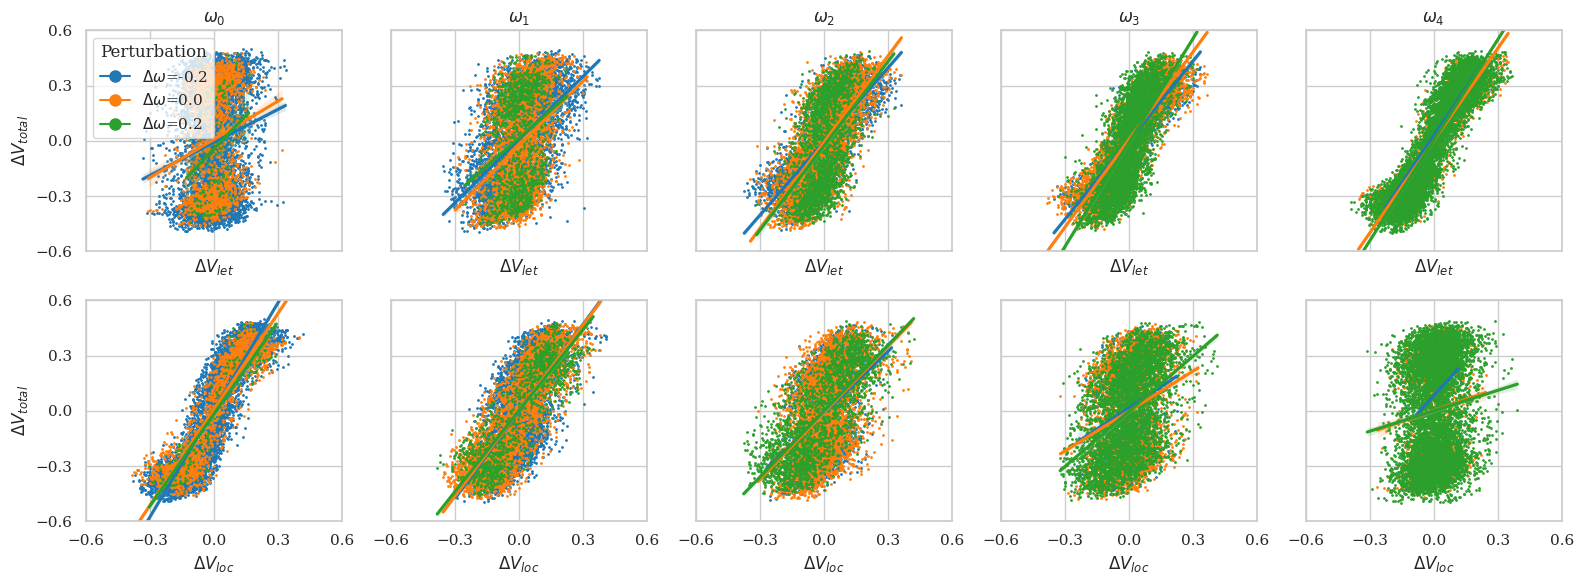

In [94]:
plot_alignment_by_omega(pert, ahead=[0,10])

In [4]:
def load_nef_spikes(file_path, root_path="/"):
    def _recurse(obj):
        retdict = {}
        for key, value in obj.items():
            if isinstance(value, h5py.Group):
                retdict[key] = _recurse(value)
            else:
                # [:] loads the dataset into a NumPy array
                retdict[key] = value[:]
        return retdict
    with h5py.File(file_path, "r") as f:
        # Navigate to the requested root_path (e.g., 'monkey1/sessionA')
        target_obj = f[root_path] if root_path != "/" else f
        return _recurse(target_obj)

In [5]:
def print_dict_structure(d, indent=0):
    for key, value in d.items():
        # Print the current key with indentation
        print('  ' * indent + f"[{key}]")
        
        # If the value is a dictionary, recurse deeper
        if isinstance(value, dict):
            print_dict_structure(value, indent + 1)
        else:
            # If it's the leaf (the NumPy array), show its shape
            print('  ' * (indent + 1) + f"Array shape: {value.shape}")

In [341]:
def generate_nef_decoding_plot():
    values = pd.read_pickle("data/nef/spikes/nef_data.pkl.xz")
    spikes = load_nef_spikes("data/nef/spikes/nef_data_spikes.h5")
    values['dv_let'] = values['vwa_a'] - values['vwa_b']
    values['dv_loc'] = values['vwa_l'] - values['vwa_r']
    values['dv_let_abs'] = np.abs(values['vwa_a'] - values['vwa_b'])
    values['dv_loc_abs'] = np.abs(values['vwa_l'] - values['vwa_r'])
    
    monkeys = ['V', 'W']
    sessions = [0,1,2,3]
    blocks = range(1, 25)
    seeds = [0]
    pert_starts = np.arange(1,81,10)
    pert_values = [0.0]  # [-0.2, 0, 0.2]
    pops = ['vwa', 'a']
    variables = ['dv_let', 'dv_loc', 'al', 'ar']
    results = []

    for m in monkeys:
        for s in sessions:
            for b in blocks:
                for e in seeds:
                    for ps in pert_starts:
                        for p in pops:
                            for pv in pert_values:
                                block_df = values.query(
                                    "monkey==@m and session==@s and block==@b and seed==@e & pert_value==@pv & pert_start==@ps").reset_index(drop=True) # Ensure 0-based integer alignment
                                if block_df.empty:
                                    print(f"missing values {m} {s} {b} {e} {ps} {p} {pv}")
                                    continue
                                try:
                                    pv_train = '0'
                                    X_data = np.array(spikes[m][str(s)][str(b)][str(e)][str(ps)][p][str(pv_train)][:])
                                except:
                                    print(f"missing spikes {m} {s} {b} {e} {ps} {p} {pv}")
                                    continue
                                for v in variables:
                                    y_data = block_df[v].values
                                    for i in range(len(y_data)):  # Leave-one-trial-out cross validation
                                        train_indices = np.delete(np.arange(len(y_data)), i)  # Mask to exclude the current trial i
                                        X_train = X_data[train_indices]
                                        y_train = y_data[train_indices]
                                        model = Ridge(alpha=1.0)
                                        model.fit(X_train, y_train)
                                        X_test = X_data[i].reshape(1, -1)  # Predict only for the excluded trial
                                        pred = model.predict(X_test)[0]
                                        err = np.sqrt(np.square(pred - y_data[i]))
                                        w = block_df.iloc[i]['w']
                                        block_type = 'what' if block_df.iloc[i]['block'] <= 12 else 'where'
                                        results.append({'pop': p, 'variable': v, 'rmse': err, 'w': w, 'block_type': block_type})
    df_results = pd.DataFrame(results)
    return df_results

In [367]:
pd.read_pickle("data/nef/spikes/nef_data.pkl.xz").columns

Index(['monkey', 'session', 'block', 'seed', 'trial', 'va', 'vb', 'vl', 'vr',
       'w', 'vwa_a', 'vwa_b', 'vwa_l', 'vwa_r', 'vwa_w', 'al', 'ar', 'dec',
       'tdec', 'thr', 'rew', 'acc', 'pert_start', 'pert_end', 'pert_value'],
      dtype='object')

In [363]:
def generate_nef_decoding_plot():
    values = pd.read_pickle("data/nef/spikes/nef_data.pkl.xz")
    spikes = load_nef_spikes("data/nef/spikes/nef_data_spikes.h5")
    values['dv_let'] = values['vwa_a'] - values['vwa_b']
    values['dv_loc'] = values['vwa_l'] - values['vwa_r']
    values['dv_let_abs'] = np.abs(values['vwa_a'] - values['vwa_b'])
    values['dv_loc_abs'] = np.abs(values['vwa_l'] - values['vwa_r'])
    
    monkeys = ['V', 'W']
    sessions = [0,1,2,3]
    blocks = range(1, 25)
    seeds = [0]
    # pert_starts = np.arange(1,81,10)
    pert_starts = [1]
    pert_values = [-0.2, 0, 0.2]
    pops = ['vwa', 'a']
    variables = ['dv_let', 'dv_loc', 'al', 'ar']
    results = []

    for m in monkeys:
        for s in sessions:
            for b in blocks:
                for e in seeds:
                    for ps in pert_starts:
                        # pe = ps + 100
                        for p in pops:
                            # Pre-load the training (baseline) spikes for this block
                            pv_train = '0'
                            try:
                                X_train_pool = np.array(spikes[m][str(s)][str(b)][str(e)][str(ps)][p][pv_train][:])
                                # Also get the ground truth for training trials
                                train_gt_df = values.query(
                                    "monkey==@m and session==@s and block==@b and seed==@e and "
                                    # "pert_value==0 and pert_start==@ps and trial>=@ps and trial<@pe"
                                    "pert_value==0 and pert_start==@ps"
                                ).reset_index(drop=True)
                            except:
                                print(f"missing training spikes/values {m} {s} {b} {ps} {p}")
                                continue

                            for pv in pert_values:
                                block_df = values.query(
                                    "monkey==@m and session==@s and block==@b and seed==@e and "
                                    # "pert_value==@pv and pert_start==@ps and trial>=@ps and trial<@pe"
                                    "pert_value==@pv and pert_start==@ps"
                                ).reset_index(drop=True)
                                
                                if block_df.empty:
                                    continue
                                
                                try:
                                    X_test_pool = np.array(spikes[m][str(s)][str(b)][str(e)][str(ps)][p][str(pv)][:])
                                except:
                                    continue

                                for v in variables:
                                    y_train_pool = train_gt_df[v].values
                                    y_test_pool = block_df[v].values
                                    
                                    for i in range(len(y_test_pool)):
                                        # LOTO: Remove the i-th trial from the pv=0 training pool
                                        # This ensures training size is always N-1
                                        train_idx = np.delete(np.arange(len(y_train_pool)), i)
                                        X_train = X_train_pool[train_idx]
                                        y_train = y_train_pool[train_idx]
                                        
                                        model = Ridge(alpha=1.0)
                                        model.fit(X_train, y_train)
                                        
                                        # Test on the i-th trial of the current pert_value
                                        X_test = X_test_pool[i].reshape(1, -1)
                                        pred = model.predict(X_test)[0]
                                        
                                        err = np.sqrt(np.square(pred - y_test_pool[i]))
                                        w = block_df.iloc[i]['w']
                                        block_type = 'what' if block_df.iloc[i]['block'] <= 12 else 'where'
                                        
                                        results.append({
                                            'pop': p, 
                                            'variable': v, 
                                            'rmse': err, 
                                            'w': w, 
                                            'block_type': block_type,
                                            'pert_value': pv
                                        })
    return pd.DataFrame(results)

In [364]:
df_v_by_w = generate_nef_decoding_plot()

missing training spikes/values V 0 17 1 vwa
missing training spikes/values V 0 17 1 a
missing training spikes/values W 0 10 1 vwa
missing training spikes/values W 0 10 1 a
missing training spikes/values W 2 12 1 vwa
missing training spikes/values W 2 12 1 a


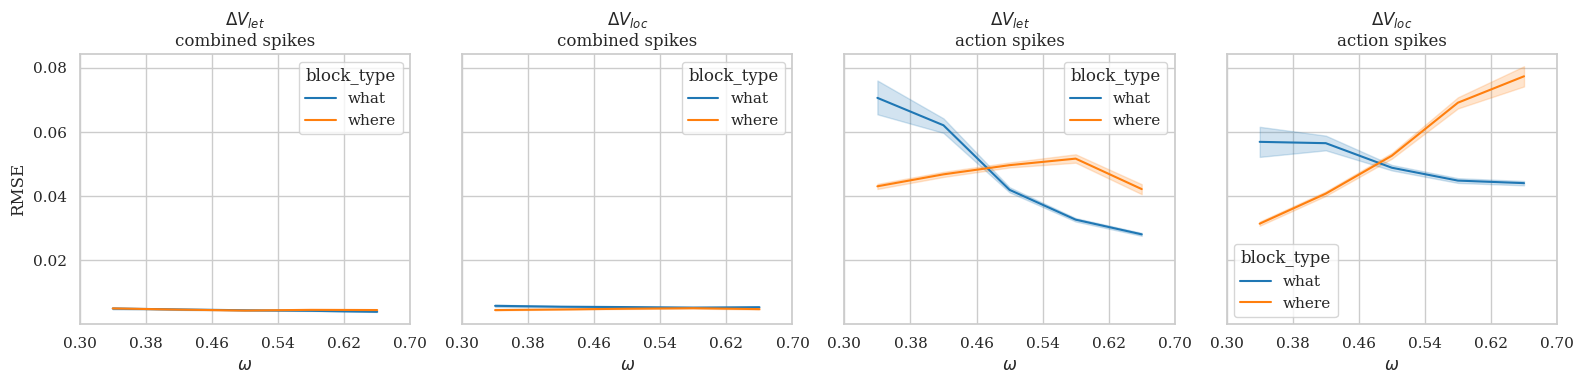

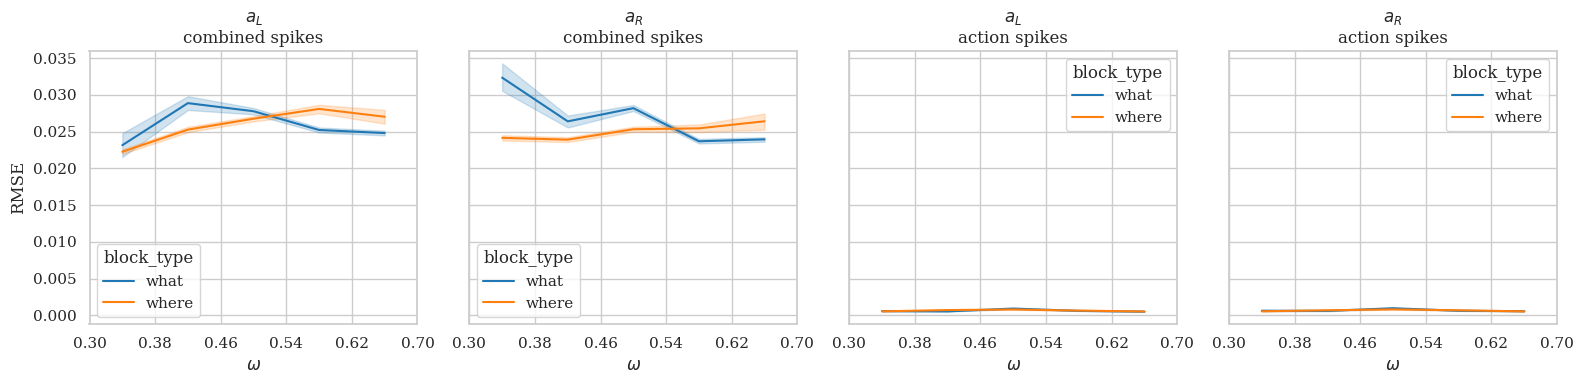

In [350]:
# 1. Prepare Binning
w_bins = np.linspace(0.3, 0.7, 6)
midpoints = (w_bins[:-1] + w_bins[1:]) / 2
# Explicitly map 'w' to the center of the bins for plotting
df_v_by_w['w_center'] = pd.cut(df_v_by_w['w'], bins=w_bins, labels=midpoints).astype(float)

# Formatting for x-axis: only first two digits
x_labels = [f"{x:.2f}" for x in w_bins]

# --- Figure 1: Delta V Variables ---
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4), sharey=True, sharex=True)

sns.lineplot(data=df_v_by_w.query("pop=='vwa' & variable=='dv_let'"), x='w_center', y='rmse', ax=axes[0], hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='vwa' & variable=='dv_loc'"), x='w_center', y='rmse', ax=axes[1], hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='a' & variable=='dv_let'"), x='w_center', y='rmse', ax=axes[2], hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='a' & variable=='dv_loc'"), x='w_center', y='rmse', ax=axes[3], hue='block_type', palette=palette[:2])

axes[0].set(xlabel=r"$\omega$", ylabel='RMSE', title=r'$\Delta V_{let}$'+'\ncombined spikes', xticks=w_bins, xticklabels=x_labels, xlim=[w_bins[0], w_bins[-1]])
axes[1].set(xlabel=r"$\omega$", ylabel=None, title=r'$\Delta V_{loc}$'+'\ncombined spikes')
axes[2].set(xlabel=r"$\omega$", ylabel=None, title=r'$\Delta V_{let}$'+'\naction spikes')
axes[3].set(xlabel=r"$\omega$", ylabel=None, title=r'$\Delta V_{loc}$'+'\naction spikes')

# Add vertical lines to show bin boundaries
for ax in axes:
    for edge in w_bins:
        ax.axvline(edge, color='gray', lw=0.5, alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()

# --- Figure 2: Action Variables ---
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4), sharey=True, sharex=True)

sns.lineplot(data=df_v_by_w.query("pop=='vwa' & variable=='al'"), x='w_center', y='rmse', ax=axes[0], hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='vwa' & variable=='ar'"), x='w_center', y='rmse', ax=axes[1], hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='a' & variable=='al'"), x='w_center', y='rmse', ax=axes[2], hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='a' & variable=='ar'"), x='w_center', y='rmse', ax=axes[3], hue='block_type', palette=palette[:2])

axes[0].set(xlabel=r"$\omega$", ylabel='RMSE', title=r'$a_L$'+'\ncombined spikes', xticks=w_bins, xticklabels=x_labels, xlim=[w_bins[0], w_bins[-1]])
axes[1].set(xlabel=r"$\omega$", ylabel=None, title=r'$a_R$'+'\ncombined spikes')
axes[2].set(xlabel=r"$\omega$", ylabel=None, title=r'$a_L$'+'\naction spikes')
axes[3].set(xlabel=r"$\omega$", ylabel=None, title=r'$a_R$'+'\naction spikes')

# Add vertical lines to show bin boundaries
for ax in axes:
    for edge in w_bins:
        ax.axvline(edge, color='gray', lw=0.5, alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()

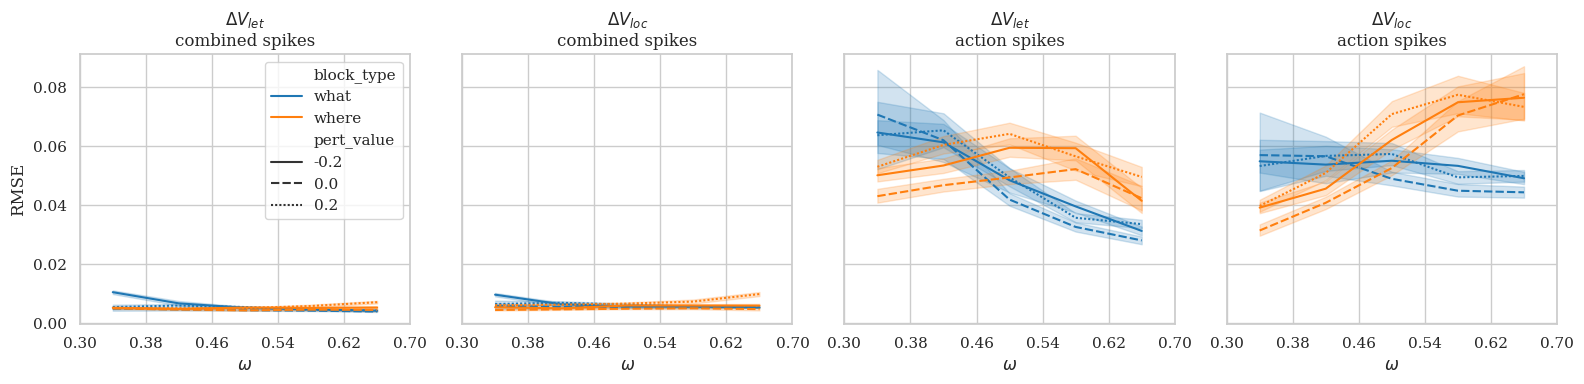

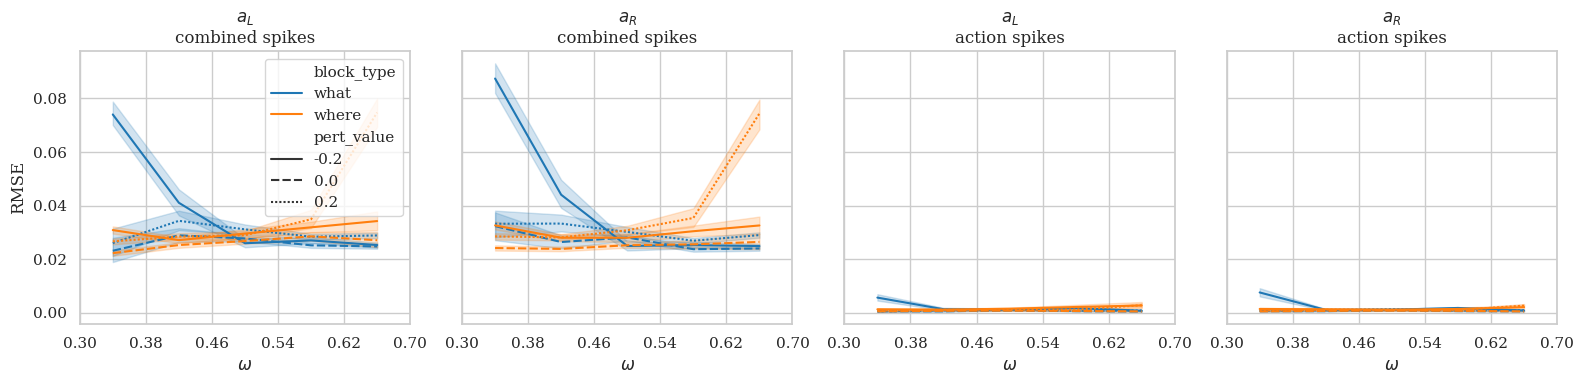

In [368]:
# 1. Prepare Binning
w_bins = np.linspace(0.3, 0.7, 6)
midpoints = (w_bins[:-1] + w_bins[1:]) / 2
# Explicitly map 'w' to the center of the bins for plotting
df_v_by_w['w_center'] = pd.cut(df_v_by_w['w'], bins=w_bins, labels=midpoints).astype(float)

# Formatting for x-axis: only first two digits
x_labels = [f"{x:.2f}" for x in w_bins]

# --- Figure 1: Delta V Variables ---
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4), sharey=True, sharex=True)

sns.lineplot(data=df_v_by_w.query("pop=='vwa' & variable=='dv_let'"), x='w_center', y='rmse', ax=axes[0], style='pert_value', hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='vwa' & variable=='dv_loc'"), x='w_center', y='rmse', ax=axes[1], style='pert_value', hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='a' & variable=='dv_let'"), x='w_center', y='rmse', ax=axes[2], style='pert_value', hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='a' & variable=='dv_loc'"), x='w_center', y='rmse', ax=axes[3], style='pert_value', hue='block_type', palette=palette[:2])

axes[0].set(xlabel=r"$\omega$", ylabel='RMSE', title=r'$\Delta V_{let}$'+'\ncombined spikes', xticks=w_bins, xticklabels=x_labels, xlim=[w_bins[0], w_bins[-1]])
axes[1].set(xlabel=r"$\omega$", ylabel=None, title=r'$\Delta V_{loc}$'+'\ncombined spikes')
axes[2].set(xlabel=r"$\omega$", ylabel=None, title=r'$\Delta V_{let}$'+'\naction spikes')
axes[3].set(xlabel=r"$\omega$", ylabel=None, title=r'$\Delta V_{loc}$'+'\naction spikes')

# Add vertical lines to show bin boundaries
for ax in axes:
    for edge in w_bins:
        ax.axvline(edge, color='gray', lw=0.5, alpha=0.5, zorder=0)
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
plt.tight_layout()
plt.show()

# --- Figure 2: Action Variables ---
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4), sharey=True, sharex=True)

sns.lineplot(data=df_v_by_w.query("pop=='vwa' & variable=='al'"), x='w_center', y='rmse', ax=axes[0], style='pert_value', hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='vwa' & variable=='ar'"), x='w_center', y='rmse', ax=axes[1], style='pert_value', hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='a' & variable=='al'"), x='w_center', y='rmse', ax=axes[2], style='pert_value', hue='block_type', palette=palette[:2])
sns.lineplot(data=df_v_by_w.query("pop=='a' & variable=='ar'"), x='w_center', y='rmse', ax=axes[3], style='pert_value', hue='block_type', palette=palette[:2])

axes[0].set(xlabel=r"$\omega$", ylabel='RMSE', title=r'$a_L$'+'\ncombined spikes', xticks=w_bins, xticklabels=x_labels, xlim=[w_bins[0], w_bins[-1]])
axes[1].set(xlabel=r"$\omega$", ylabel=None, title=r'$a_R$'+'\ncombined spikes')
axes[2].set(xlabel=r"$\omega$", ylabel=None, title=r'$a_L$'+'\naction spikes')
axes[3].set(xlabel=r"$\omega$", ylabel=None, title=r'$a_R$'+'\naction spikes')

# Add vertical lines to show bin boundaries
for ax in axes:
    for edge in w_bins:
        ax.axvline(edge, color='gray', lw=0.5, alpha=0.5, zorder=0)
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
plt.tight_layout()
plt.show()

## Omega quantiles and cross validation

In [6]:
def pseudo_r2_decoding(n_splits=10, n_omega_bins=5, n_shuffle=10):
    """
    Computes Pseudo R2 = 1 - (MSE_model / MSE_shuffled)
    as a function of omega quantiles.
    """
    # Load behavioral data and spikes
    values = pd.read_pickle("data/nef/spikes/nef_data.pkl.xz")
    spikes = load_nef_spikes("data/nef/spikes/nef_data_spikes.h5")
    
    # Feature Engineering
    values['dv_let'] = values['vwa_a'] - values['vwa_b']
    values['dv_loc'] = values['vwa_l'] - values['vwa_r']
    
    monkeys = ['V', 'W']
    sessions = [0, 1, 2, 3]
    blocks = range(1, 25)
    seeds = [0]
    pert_starts = [1]
    pops = ['vwa', 'a']
    variables = ['dv_let', 'dv_loc', 'al', 'ar']
    results = []

    for m in monkeys:
        for s in sessions:
            for b in blocks:
                print(f"monkey {m} session {s} block {b}")
                for e in seeds:
                    for ps in pert_starts:
                        # 1. Filter for the specific experimental block (baseline trials only)
                        block_mask = (values.monkey == m) & (values.session == s) & \
                                     (values.block == b) & (values.seed == e) & \
                                     (values.pert_value == 0) & (values.pert_start == ps)
                        
                        block_df = values[block_mask].copy().reset_index(drop=True)
                        if block_df.empty:
                            continue

                        # 2. Define Omega Quantiles for this specific block
                        try:
                            block_df['w_quantile'] = pd.qcut(block_df['w'], n_omega_bins, labels=False)
                        except ValueError: 
                            continue

                        for p in pops:
                            try:
                                # Retrieve spike matrix for this population: (trials, neurons)
                                X_block = np.array(spikes[m][str(s)][str(b)][str(e)][str(ps)][p]['0'][:])
                            except KeyError:
                                continue

                            for q in range(n_omega_bins):
                                # Get trial indices belonging to this quantile
                                q_idx = block_df.index[block_df['w_quantile'] == q].tolist()
                                if len(q_idx) < n_splits: 
                                    continue 
                                
                                X_q = X_block[q_idx]
                                w_q_mean = block_df.loc[q_idx, 'w'].mean()
                                block_type = 'what' if b <= 12 else 'where'

                                for v in variables:
                                    y_q = block_df.loc[q_idx, v].values
                                    
                                    # --- 3. Cross-Validated Model MSE ---
                                    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
                                    y_preds = np.zeros_like(y_q)
                                    
                                    for train_idx, test_idx in kf.split(X_q):
                                        model = Ridge(alpha=1.0)
                                        model.fit(X_q[train_idx], y_q[train_idx])
                                        y_preds[test_idx] = model.predict(X_q[test_idx])
                                    
                                    mse_model = np.mean((y_q - y_preds)**2)

                                    # --- 4. Cross-Validated Shuffled MSE (Baseline) ---
                                    shuffled_mses = []
                                    for _ in range(n_shuffle):
                                        # Randomize spike-label correspondence
                                        X_q_shf = X_q.copy()
                                        np.random.shuffle(X_q_shf)
                                        
                                        y_preds_null = np.zeros_like(y_q)
                                        for train_idx, test_idx in kf.split(X_q_shf):
                                            model_null = Ridge(alpha=1.0)
                                            model_null.fit(X_q_shf[train_idx], y_q[train_idx])
                                            y_preds_null[test_idx] = model_null.predict(X_q_shf[test_idx])
                                        
                                        shuffled_mses.append(np.mean((y_q - y_preds_null)**2))
                                    
                                    mse_shuffled = np.mean(shuffled_mses)

                                    # --- 5. Final Pseudo R2 Calculation ---
                                    # Logic: 1 - (Error of Model / Error of Chance)
                                    pseudo_r2 = 1 - (mse_model / mse_shuffled)
                                    
                                    # Center lower bound at zero for interpretability
                                    pseudo_r2 = max(0, pseudo_r2)

                                    results.append({
                                        'monkey': m,
                                        'session': s,
                                        'block': b,
                                        'pop': p, 
                                        'variable': v, 
                                        'pseudo_r2': pseudo_r2,
                                        'w_mean': w_q_mean, 
                                        'quantile': q,
                                        'block_type': block_type
                                    })

    return pd.DataFrame(results)

In [7]:
nef_pr2 = pseudo_r2_decoding()

monkey V session 0 block 1
monkey V session 0 block 2
monkey V session 0 block 3
monkey V session 0 block 4
monkey V session 0 block 5
monkey V session 0 block 6
monkey V session 0 block 7
monkey V session 0 block 8
monkey V session 0 block 9
monkey V session 0 block 10
monkey V session 0 block 11
monkey V session 0 block 12
monkey V session 0 block 13
monkey V session 0 block 14
monkey V session 0 block 15
monkey V session 0 block 16
monkey V session 0 block 17
monkey V session 0 block 18
monkey V session 0 block 19
monkey V session 0 block 20
monkey V session 0 block 21
monkey V session 0 block 22
monkey V session 0 block 23
monkey V session 0 block 24
monkey V session 1 block 1
monkey V session 1 block 2
monkey V session 1 block 3
monkey V session 1 block 4
monkey V session 1 block 5
monkey V session 1 block 6
monkey V session 1 block 7
monkey V session 1 block 8
monkey V session 1 block 9
monkey V session 1 block 10
monkey V session 1 block 11
monkey V session 1 block 12
monkey V s

In [8]:
nef_pr2

monkey  session  block  pop variable  pseudo_r2    w_mean  quantile  \
0         V        0      1  vwa   dv_let   0.969712  0.516468         0   
1         V        0      1  vwa   dv_loc   0.848769  0.516468         0   
2         V        0      1  vwa       al   0.863131  0.516468         0   
3         V        0      1  vwa       ar   0.881919  0.516468         0   
4         V        0      1  vwa   dv_let   0.972721  0.545405         1   
...     ...      ...    ...  ...      ...        ...       ...       ...   
7555      W        3     24    a       ar   0.995286  0.498061         3   
7556      W        3     24    a   dv_let   0.461961  0.536598         4   
7557      W        3     24    a   dv_loc   0.239971  0.536598         4   
7558      W        3     24    a       al   0.998608  0.536598         4   
7559      W        3     24    a       ar   0.999006  0.536598         4   

     block_type  
0          what  
1          what  
2          what  
3          what  
4          what  
...         ...  
7555      where  
7556      where  
7557      where  
7558      where  
7559      where  

[7560 rows x 9 columns]

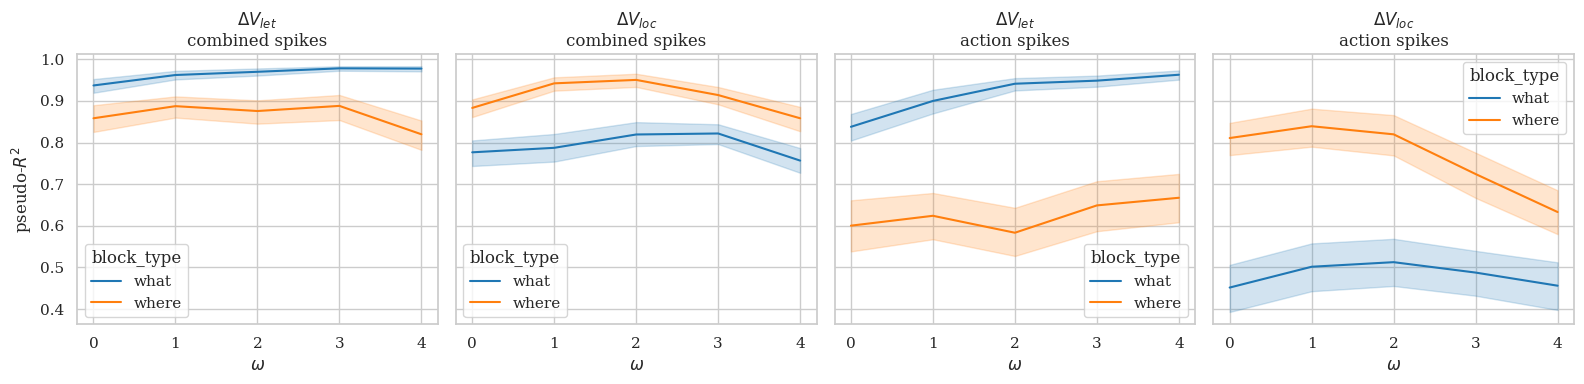

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4), sharey=True, sharex=True)

# sns.lineplot(data=nef_pr2.query("pop=='vwa' & variable=='dv_let'"), x='quantile', y='pseudo_r2', ax=axes[0], color=palette[0])
# sns.lineplot(data=nef_pr2.query("pop=='vwa' & variable=='dv_loc'"), x='quantile', y='pseudo_r2', ax=axes[1], color=palette[0])
# sns.lineplot(data=nef_pr2.query("pop=='a' & variable=='dv_let'"), x='quantile', y='pseudo_r2', ax=axes[2], color=palette[0])
# sns.lineplot(data=nef_pr2.query("pop=='a' & variable=='dv_loc'"), x='quantile', y='pseudo_r2', ax=axes[3], color=palette[0])

sns.lineplot(data=nef_pr2.query("pop=='vwa' & variable=='dv_let'"), x='quantile', y='pseudo_r2', ax=axes[0], hue='block_type', palette=palette[:2])
sns.lineplot(data=nef_pr2.query("pop=='vwa' & variable=='dv_loc'"), x='quantile', y='pseudo_r2', ax=axes[1], hue='block_type', palette=palette[:2])
sns.lineplot(data=nef_pr2.query("pop=='a' & variable=='dv_let'"), x='quantile', y='pseudo_r2', ax=axes[2], hue='block_type', palette=palette[:2])
sns.lineplot(data=nef_pr2.query("pop=='a' & variable=='dv_loc'"), x='quantile', y='pseudo_r2', ax=axes[3], hue='block_type', palette=palette[:2])

axes[0].set(xlabel=r"$\omega$", ylabel=r'pseudo-$R^2$', title=r'$\Delta V_{let}$'+'\ncombined spikes')
axes[1].set(xlabel=r"$\omega$", ylabel=None, title=r'$\Delta V_{loc}$'+'\ncombined spikes')
axes[2].set(xlabel=r"$\omega$", ylabel=None, title=r'$\Delta V_{let}$'+'\naction spikes')
axes[3].set(xlabel=r"$\omega$", ylabel=None, title=r'$\Delta V_{loc}$'+'\naction spikes')

# axes[1].get_legend().remove()
# axes[2].get_legend().remove()
# axes[3].get_legend().remove()
plt.tight_layout()
plt.show()

### lump blocks together

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

def generate_nef_pseudo_r2_session_wide(n_splits=10, n_omega_bins=5, n_shuffle=100):
    values = pd.read_pickle("data/nef/spikes_block/nef_data.pkl.xz")
    spikes = load_nef_spikes("data/nef/spikes_block/nef_data_spikes.h5")
    
    values['dv_let'] = values['vwa_a'] - values['vwa_b']
    values['dv_loc'] = values['vwa_l'] - values['vwa_r']
    
    monkeys = ['V', 'W']
    sessions = [0, 1, 2, 3]
    seeds = [0, 1, 2]
    ps = 1
    pop = 'a'
    variables = ['dv_let', 'dv_loc', 'al', 'ar']
    results = []

    for m in monkeys:
        for s in sessions:
            for e in seeds:
                print(f"monkey {m} session {s} seed {e}")
                
                # Iterate through block types to keep contexts separate
                for bt in ['what', 'where']:
                    # Filter for specific block type within the session
                    # 'what' is blocks 1-12, 'where' is 13-24
                    if bt == 'what':
                        bt_mask = (values.block <= 12)
                    else:
                        bt_mask = (values.block > 12)

                    session_mask = (values.monkey == m) & (values.session == s) & \
                                   (values.seed == e) & (values.pert_value == 0) & \
                                   (values.pert_start == ps) & bt_mask
                    
                    session_df = values[session_mask].copy().reset_index(drop=True)
                    if session_df.empty:
                        continue

                    # Define Omega Quantiles specifically for this block type context
                    try:
                        session_df['w_quantile'] = pd.qcut(session_df['w'], n_omega_bins, labels=False)
                    except ValueError:
                        continue

                    # Collect spikes across the pooled blocks
                    session_spikes = []
                    valid_indices = []
                    
                    for idx, row in session_df.iterrows():
                        b = row['block']
                        trial = row['trial']
                        try:
                            # Accessing the trial-indexed spike matrix
                            spike_vec = spikes[m][str(s)][str(b)][str(e)][str(ps)][pop]['0'][trial, :]
                            session_spikes.append(spike_vec)
                            valid_indices.append(idx)
                        except (KeyError, IndexError):
                            continue
                    
                    if not session_spikes:
                        continue
                        
                    X_session = np.array(session_spikes)
                    session_df_clean = session_df.iloc[valid_indices].reset_index(drop=True)

                    for q in range(n_omega_bins):
                        q_idx = session_df_clean.index[session_df_clean['w_quantile'] == q].tolist()
                        if len(q_idx) < n_splits:
                            continue
                        
                        X_q = X_session[q_idx]
                        w_q_mean = session_df_clean.loc[q_idx, 'w'].mean()
                        
                        for v in variables:
                            y_q = session_df_clean.loc[q_idx, v].values
                            
                            # --- Cross-Validated Model MSE ---
                            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
                            y_preds = np.zeros_like(y_q)
                            
                            for train_idx, test_idx in kf.split(X_q):
                                model = Ridge(alpha=1.0)
                                model.fit(X_q[train_idx], y_q[train_idx])
                                y_preds[test_idx] = model.predict(X_q[test_idx])
                            
                            mse_model = np.mean((y_q - y_preds)**2)

                            # --- Cross-Validated Shuffled MSE ---
                            shuffled_mses = []
                            for _ in range(n_shuffle):
                                X_q_shf = X_q.copy()
                                np.random.shuffle(X_q_shf)
                                
                                y_preds_null = np.zeros_like(y_q)
                                for train_idx, test_idx in kf.split(X_q_shf):
                                    model_null = Ridge(alpha=1.0)
                                    model_null.fit(X_q_shf[train_idx], y_q[train_idx])
                                    y_preds_null[test_idx] = model_null.predict(X_q_shf[test_idx])
                                
                                shuffled_mses.append(np.mean((y_q - y_preds_null)**2))
                            
                            mse_shuffled = np.mean(shuffled_mses)
                            pseudo_r2 = max(0, 1 - (mse_model / mse_shuffled))

                            results.append({
                                'monkey': m,
                                'session': s,
                                'seed': e,
                                'pop': pop,
                                'variable': v,
                                'block_type': bt,
                                'pseudo_r2': pseudo_r2,
                                'w_mean': w_q_mean,
                                'quantile': q,
                                'n_trials': len(q_idx)
                            })

    return pd.DataFrame(results)

In [31]:
nef_pr2_block = generate_nef_pseudo_r2_session_wide()

monkey V session 0 seed 0
monkey V session 0 seed 1
monkey V session 0 seed 2
monkey V session 1 seed 0
monkey V session 1 seed 1
monkey V session 1 seed 2
monkey V session 2 seed 0
monkey V session 2 seed 1
monkey V session 2 seed 2
monkey V session 3 seed 0
monkey V session 3 seed 1
monkey V session 3 seed 2
monkey W session 0 seed 0
monkey W session 0 seed 1
monkey W session 0 seed 2
monkey W session 1 seed 0
monkey W session 1 seed 1
monkey W session 1 seed 2
monkey W session 2 seed 0
monkey W session 2 seed 1
monkey W session 2 seed 2
monkey W session 3 seed 0
monkey W session 3 seed 1
monkey W session 3 seed 2


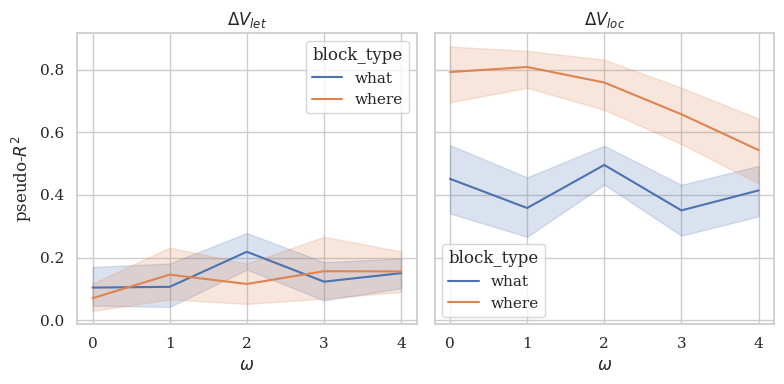

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True, sharex=True)
sns.lineplot(data=nef_pr2_block.query("variable=='dv_let'"), x='quantile', y='pseudo_r2', hue='block_type', ax=axes[0])
sns.lineplot(data=nef_pr2_block.query("variable=='dv_loc'"), x='quantile', y='pseudo_r2', hue='block_type', ax=axes[1])
axes[0].set(xlabel=r"$\omega$", ylabel=r'pseudo-$R^2$', title=r'$\Delta V_{let}$')
axes[1].set(xlabel=r"$\omega$", ylabel=None, title=r'$\Delta V_{loc}$')
plt.tight_layout()
plt.show()

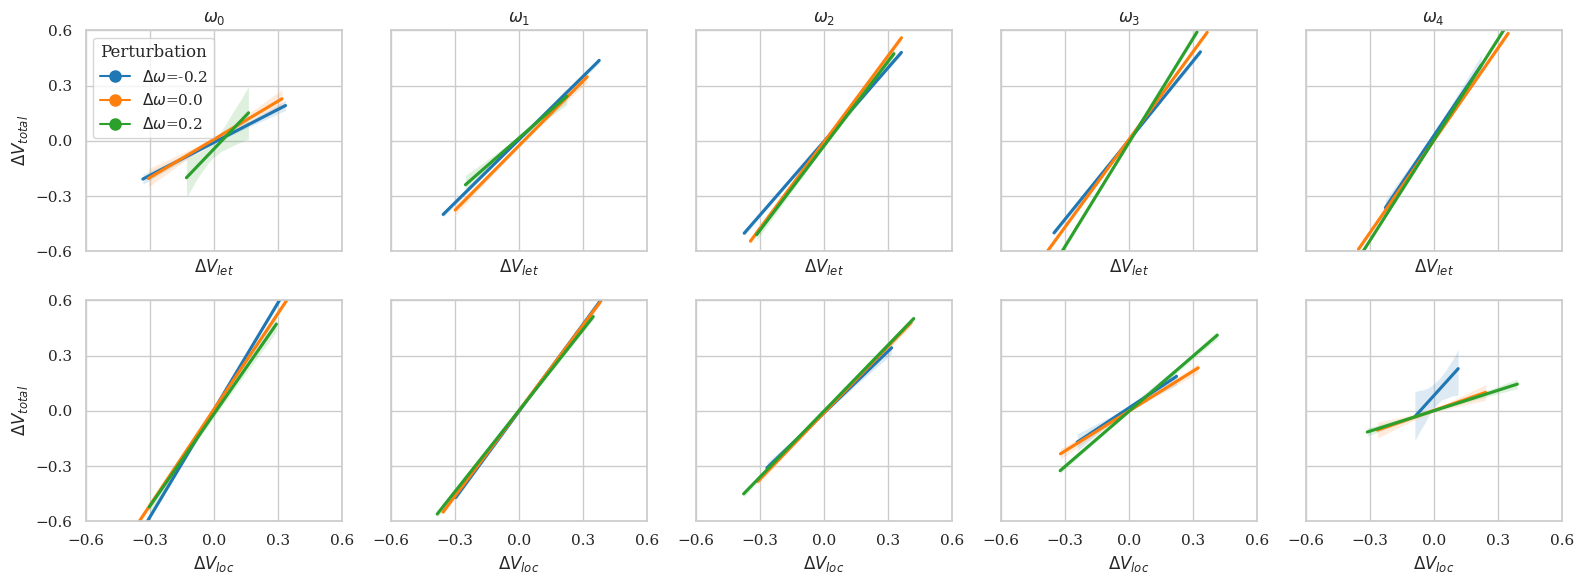

In [95]:
plot_alignment_by_omega(pert, ahead=[0,10], do_scatter=False)